# 1. Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import math
import pickle
import os

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold, StratifiedKFold
from prettytable import PrettyTable
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics._classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from datetime import datetime

# 2. Application Train/Test Datasets

In [2]:
# Refer :- https://www.kaggle.com/rinnqd/reduce-memory-usage

def reduce_memory_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## 2.1.  Basic Overview of the Train Data

In [3]:
# train_data = pd.read_csv(
#     "s3://lakehouse/raw/application_train.csv",
#     storage_options={
#         "key":    "minio",            # AWS_ACCESS_KEY_ID
#         "secret": "minio_admin",      # AWS_SECRET_ACCESS_KEY
#         "client_kwargs": {
#             "endpoint_url": "http://localhost:9000"
#         }
#     }
# )
# print("N rows:", train_data.shape[0])
# print("N cols:", train_data.shape[1])
#
# train_data = reduce_memory_usage(train_data)


train_data = reduce_memory_usage(pd.read_csv('../data/raw/application_train.csv'))
print('Number of data points : ', train_data.shape[0])
print('Number of features : ', train_data.shape[1])
train_data.head()

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Number of data points :  307511
Number of features :  122


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print('Features : ', train_data.columns.values)

Features :  ['SK_ID_CURR' 'TARGET' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES

## 2.2. Basic Overview of the Test Data

In [5]:
import pandas as pd

# test_data = reduce_memory_usage(
#     pd.read_csv(
#         "s3://lakehouse/raw/application_test.csv",
#         storage_options={
#             "key": "minio",                # AWS_ACCESS_KEY_ID của MinIO
#             "secret": "minio_admin",       # AWS_SECRET_ACCESS_KEY của MinIO
#             "client_kwargs": {
#                 "endpoint_url": "http://localhost:9000"  # URL MinIO bạn đã expose
#             }
#         }
#     )
# )
#
# print("Number of data points : ", test_data.shape[0])
# print("Number of features    : ", test_data.shape[1])
# test_data.head()

test_data = reduce_memory_usage(
    pd.read_csv('../data/raw/application_test.csv')
)

print('Number of data points : ', test_data.shape[0])
print('Number of features    : ', test_data.shape[1])
test_data.head()

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Number of data points :  48744
Number of features    :  121


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3. Application Train Data Analysis

### 2.3.1. Univariate Analysis : Target

In [6]:
train_data['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

Number of customers who will not repay the loan on time:  24825 , ( 8.072881945686495 %)
Number of customers who will repay the loan on time:  282686 , ( 91.92711805431351 %)


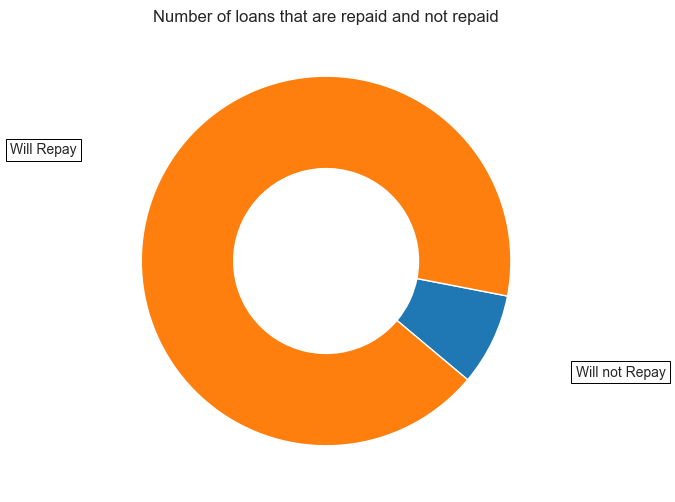

In [7]:
# Refer :- https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

y_value_counts = train_data['TARGET'].value_counts()
print("Number of customers who will not repay the loan on time: ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of customers who will repay the loan on time: ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Will not Repay", "Will Repay"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5),\
                       startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of loans that are repaid and not repaid")

plt.show()

In [8]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])

    if len(data[xtick].unique())<5:
        plt.figure(figsize=(5,5))
    elif len(data[xtick].unique())>5 & len(data[xtick].unique())<10:
        plt.figure(figsize=(7,7))
    else:
        plt.figure(figsize=(15,15))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Loans')
    plt.title('Number of loans aproved vs rejected')
    plt.xticks(ticks=ind,rotation=90,labels= list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('capable', 'not capable'))
    plt.show()

In [9]:
 def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

    temp.sort_values(by=['total'],inplace=True, ascending=False)

    if top:
        temp = temp[0:top]

    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

### 2.3.2. Univariate Analysis : Name_Contract_Type

In [10]:
train_data['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

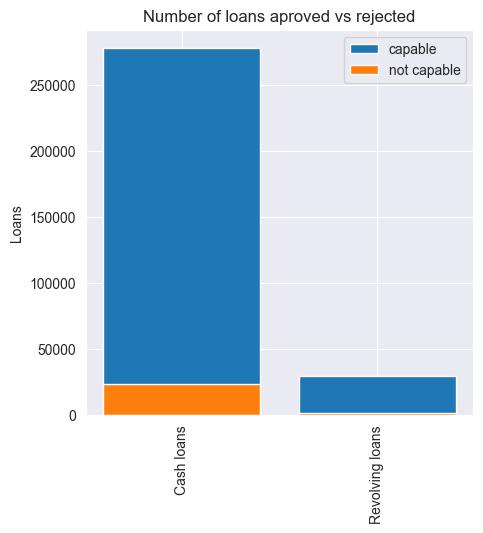

  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783
  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [11]:
univariate_barplots(train_data, 'NAME_CONTRACT_TYPE', 'TARGET', False)

**Observations:**
- Most of the people are taking loans in the form of cash loans instead of revolving loans such as credit cards.

### 2.3.3. Univariate Analysis : Code_Gender

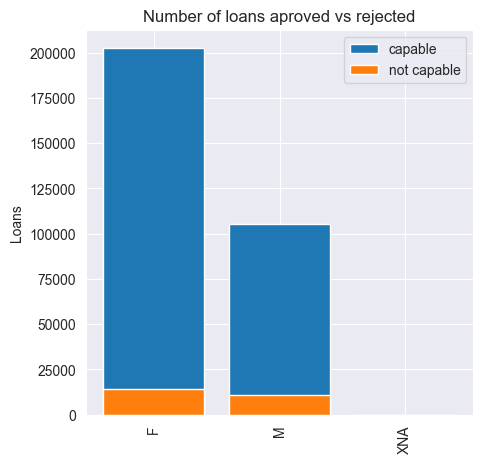

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000
  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [12]:
univariate_barplots(train_data, 'CODE_GENDER', 'TARGET', False)

**Observations:**
- The interesting part over here is the fact that Women took much more number of loans as compared to Men : Whereas Women took a total of 202K+ loans, Men only took 105K+ loans.
- However, at the same time, Men are slightly more capable of repaying the loan as compared to Women. Whereas Men are able to repay their loans in 10% of the cases, Women are only able to repay in 7% of the cases.
- There are 4 entries where Gender='XNA'. Since this is not providing us with much information, we can remove these entries later on.

### 2.3.4. Univariate Analysis : Flag_Own_Car

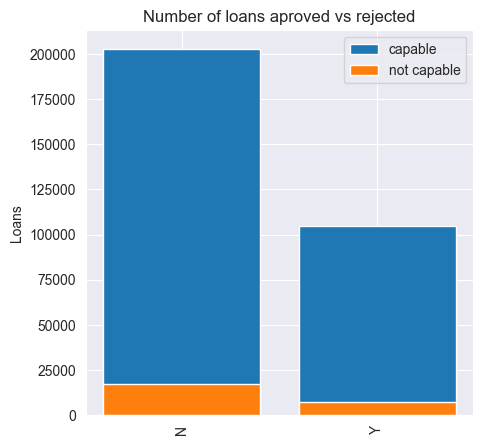

  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437
  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437


In [13]:
univariate_barplots(train_data, 'FLAG_OWN_CAR', 'TARGET', False)

**Observations:**
- Most of the applicants for loans do not own a car.
- However, there is not much difference in the loan repayment status for the customer based on this information (8.5% and 7.2% respectively). We can conclude that this feature is not very useful.

### 2.3.5 Univariate Analysis : Flag_Own_Realty

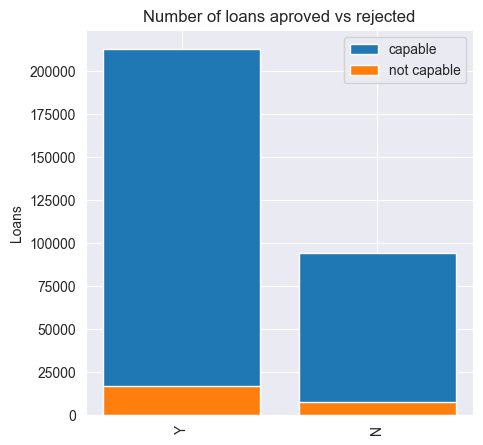

  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249
  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249


In [14]:
univariate_barplots(train_data, 'FLAG_OWN_REALTY', 'TARGET', False)

**Observations:**
- Most of the applicants for loans own a flat/house, which is a little surprising.
- However, again, there is not much difference in the loan repayment status for the customer based on this information (7.9% and 8.3% respectively). We can conclude that this feature is not very useful.

### 2.3.6 Univariate Analysis : Cnt_Children

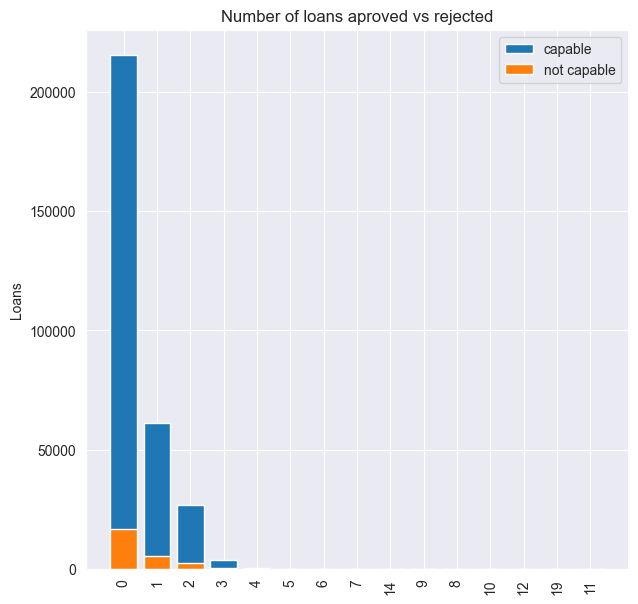

   CNT_CHILDREN  TARGET   total       Avg
0             0   16609  215371  0.077118
1             1    5454   61119  0.089236
2             2    2333   26749  0.087218
3             3     358    3717  0.096314
4             4      55     429  0.128205
    CNT_CHILDREN  TARGET  total  Avg
8              8       0      2  0.0
10            10       0      2  0.0
12            12       0      2  0.0
14            19       0      2  0.0
11            11       1      1  1.0


In [15]:
univariate_barplots(train_data, 'CNT_CHILDREN', 'TARGET', False)

**Observations:**
- The applicants having no children take considerably higher number of loans.
- However, again, there is not much difference in the loan repayment status for the customer based on this information. We can conclude that this feature is not very useful.

### 2.3.7 Univariate Analysis : Amt_Income_Total

In [16]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
income_data = train_data.groupby('SK_ID_CURR').agg({'AMT_INCOME_TOTAL':'mean'}).reset_index()
income_data.head(2)

,SK_ID_CURR,AMT_INCOME_TOTAL
0,100002,202500.0
1,100003,270000.0


In [17]:
income_data_final = pd.merge(train_data, income_data, on='SK_ID_CURR', how='left')

approved_income = income_data_final[income_data_final['TARGET']==0]['AMT_INCOME_TOTAL_x'].values
rejected_income = income_data_final[income_data_final['TARGET']==1]['AMT_INCOME_TOTAL_x'].values

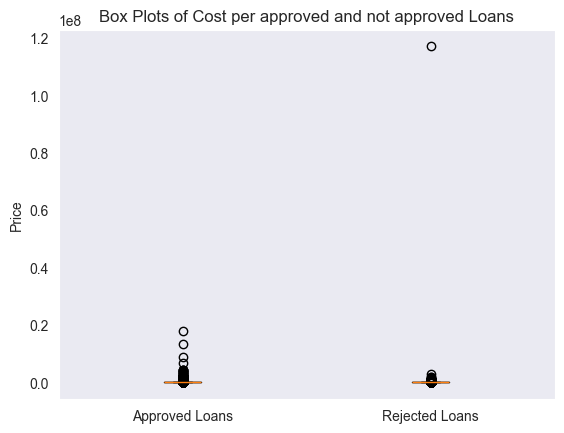

In [18]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_income, rejected_income])
plt.title('Box Plots of Cost per approved and not approved Loans')
plt.xticks([1,2],('Approved Loans','Rejected Loans'))
plt.ylabel('Price')
plt.grid()
plt.show()

In [19]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Loans", "Not Approved Loans"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_income,i), 3),\
               np.round(np.percentile(rejected_income,i), 3)])
print(x)

+------------+----------------+--------------------+
| Percentile | Approved Loans | Not Approved Loans |
+------------+----------------+--------------------+
|     0      |    25650.0     |      25650.0       |
|     5      |    67500.0     |      67500.0       |
|     10     |    81000.0     |      81000.0       |
|     15     |    90000.0     |      90000.0       |
|     20     |    99000.0     |      99000.0       |
|     25     |    112500.0    |      112500.0      |
|     30     |    112500.0    |      112500.0      |
|     35     |    126000.0    |      120873.2      |
|     40     |    135000.0    |      135000.0      |
|     45     |    135000.0    |      135000.0      |
|     50     |    148500.0    |      135000.0      |
|     55     |    157500.0    |      157500.0      |
|     60     |    166500.0    |      157500.0      |
|     65     |    180000.0    |      175500.0      |
|     70     |    185400.0    |      180000.0      |
|     75     |    202500.0    |      202500.0 

**Kết luận rút ra:**
- Tại các percentiles thấp (dưới khoảng 45%), thu nhập của hai nhóm khá tương đương.
- Ở các percentiles cao hơn, thu nhập càng lớn thì tỷ lệ được duyệt khoản vay càng cao.

### 2.3.8. Univariate Analysis : Amt_Credit

In [20]:
# for i in train_data.groupby('SK_ID_CURR',as_index=False).size():
#     if i>1:
#         print(i)
#This means that each row in the train_data has a unique SK_ID_CURR

In [21]:
train_data[train_data['SK_ID_CURR']==100002]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
approved_loan_credit = train_data[train_data['TARGET']==0]['AMT_CREDIT'].values
rejected_loan_credit = train_data[train_data['TARGET']==1]['AMT_CREDIT'].values

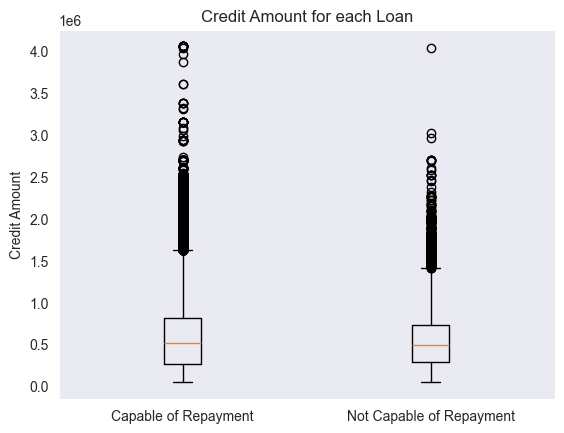

In [23]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_loan_credit, rejected_loan_credit])
plt.title('Credit Amount for each Loan')
plt.xticks([1,2],('Capable of Repayment','Not Capable of Repayment'))
plt.ylabel('Credit Amount')
plt.grid()
plt.show()

**Kết luận rút ra:**
- Khoảng giá trị vay chủ yếu tập trung ở mức trung bình → không quá rộng.
- Nhóm vay với số tiền lớn hơn trung bình có xu hướng trả được nợ cao hơn nhóm vay ít.
- Tuy hiệu quả không quá mạnh, nhưng biến AMT_CREDIT vẫn mang thông tin phân biệt nhẹ giữa hai nhóm, có thể được đưa vào model như một feature đơn giản nhưng hữu ích.

### 2.3.9 Univariate Analysis : Amt_Annuity

In [24]:
# Số tiền phải trả hàng kỳ của khoản vay
capable_loan_annuity = train_data[train_data['TARGET']==0]['AMT_ANNUITY'].values
not_capable_loan_annuity = train_data[train_data['TARGET']==1]['AMT_ANNUITY'].values

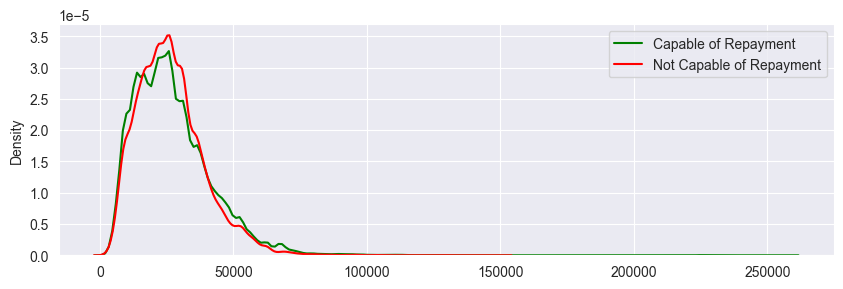

In [25]:
plt.figure(figsize=(10,3))
sns.distplot(capable_loan_annuity,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_annuity,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
- Hầu hết các khoản annuity đều nằm dưới khoảng 50.000 (đơn vị tiền), tức phần lớn khách hàng có giá trị thanh toán kỳ hạn không quá cao.
- Nếu hai đường mật độ của hai nhóm gần như chồng lên nhau thì biến này ít phân biệt được hai lớp, nhưng nếu nhóm không trả được có xu hướng tập trung quanh giá thấp hoặc có đuôi dài khác biệt thì AMT_ANNUITY vẫn có thể mang tín hiệu dự báo.

### 2.3.10 Univariate Analysis : Amt_Goods_Price

In [26]:
capable_loan_goods_price = train_data[train_data['TARGET']==0]['AMT_GOODS_PRICE'].values
not_capable_loan_goods_price = train_data[train_data['TARGET']==1]['AMT_GOODS_PRICE'].values

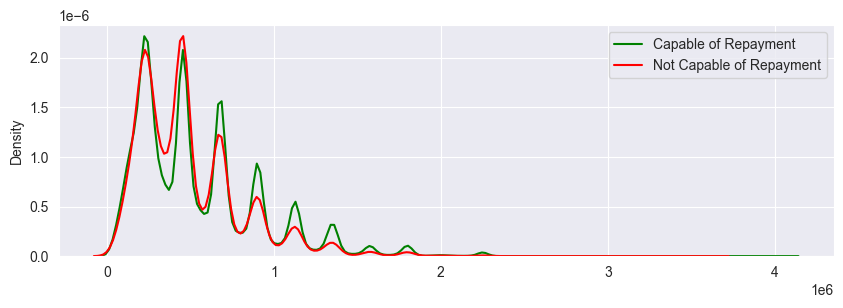

In [27]:
plt.figure(figsize=(10,3))
sns.distplot(capable_loan_goods_price,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_goods_price,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Phần lớn các khoản vay tập trung vào món hàng có giá dưới 1.000.000 (tương đương 10 lakhs).
* Nếu đường cong của hai nhóm lệch nhau ở các mức giá cao hoặc thấp, nghĩa là giá trị món hàng cũng có thể ảnh hưởng đến khả năng trả nợ. Ở đây, do cả hai curve tương đối chồng gần lên nhau, biến này có thể không phân biệt quá mạnh giữa hai nhóm—nhưng vẫn đáng đưa vào thử nghiệm trong mô hình.

### 2.3.11 Univariate Analysis : Name_Type_Suite

In [28]:
train_data['NAME_TYPE_SUITE'].unique() #kiểu người đi kèm khách hàng khi đến vay

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

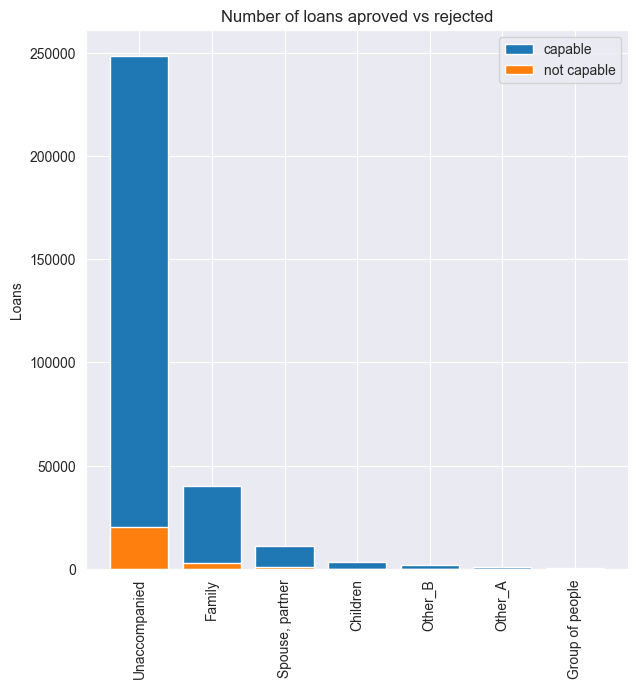

   NAME_TYPE_SUITE  TARGET   total       Avg
6    Unaccompanied   20337  248526  0.081830
1           Family    3009   40149  0.074946
5  Spouse, partner     895   11370  0.078716
0         Children     241    3267  0.073768
4          Other_B     174    1770  0.098305
   NAME_TYPE_SUITE  TARGET  total       Avg
5  Spouse, partner     895  11370  0.078716
0         Children     241   3267  0.073768
4          Other_B     174   1770  0.098305
3          Other_A      76    866  0.087760
2  Group of people      23    271  0.084871


In [29]:
univariate_barplots(train_data, 'NAME_TYPE_SUITE', 'TARGET', False)

_**_Kết luận rút ra:_**_
* “Unaccompanied” là hạng mục phổ biến nhất (248 526 khách), với ~8.18% tỷ lệ default → tức ~91.82% trả được
* Tiếp theo là “Family” (40 149 khách, default ~7.49%), “Spouse, partner”, “Children”
* Ở nhóm ít phổ biến hơn (Other_A, Other_B, Group of people), tỷ lệ default dao động ~8.7–9.8%
* Đường “curve” rơi khá nhanh về các nhóm nhỏ, thể hiện độ không cân bằng giữa các class (“Unaccompanied” chiếm áp đảo)

### 2.3.12 Univariate Analysis : Name_Income_Type

In [30]:
train_data['NAME_INCOME_TYPE'].unique() # Nhóm thu nhập

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

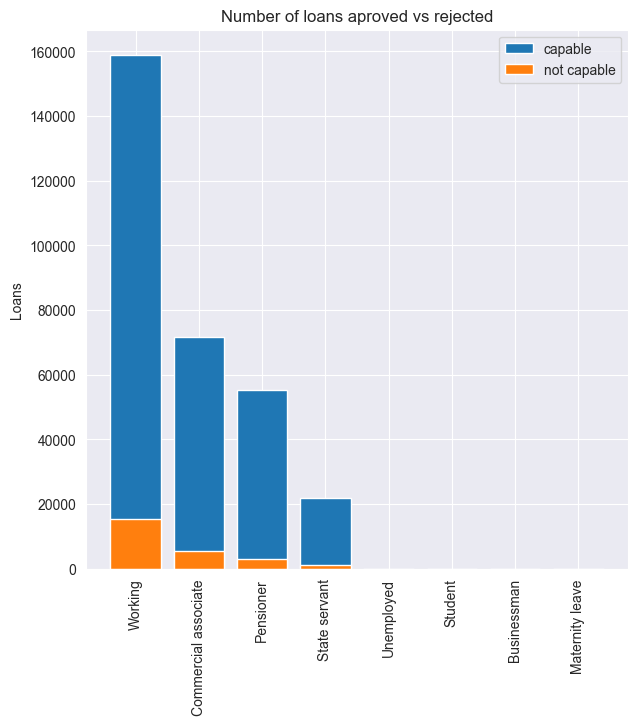

       NAME_INCOME_TYPE  TARGET   total       Avg
7               Working   15224  158774  0.095885
1  Commercial associate    5360   71617  0.074843
3             Pensioner    2982   55362  0.053864
4         State servant    1249   21703  0.057550
6            Unemployed       8      22  0.363636
  NAME_INCOME_TYPE  TARGET  total       Avg
4    State servant    1249  21703  0.057550
6       Unemployed       8     22  0.363636
5          Student       0     18  0.000000
0      Businessman       0     10  0.000000
2  Maternity leave       2      5  0.400000


In [31]:
train_data['NAME_INCOME_TYPE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'NAME_INCOME_TYPE', 'TARGET', False)

**Kết luận rút ra:**
* “Working” (làm việc ổn định) là nhóm đông nhất, chiếm hơn 75% dữ liệu, với ~9.6% vỡ nợ.
* Nhóm “Commercial associate”, “Pensioner”, “State servant” đều có tỉ lệ default thấp hơn (5–7%), cho thấy thu nhập từ kinh doanh, lương hưu hay công chức ít rủi ro hơn trung bình.
* Các nhóm hiếm như Unemployed, Maternity leave mặc dù rất ít người nhưng có tỉ lệ vỡ nợ rất cao (~36–40%) — tuy sample nhỏ nhưng đáng lưu ý.
* Hai nhóm Student và Businessman dù dữ liệu rất ít (<20, <10 record) đều có 0% vỡ nợ, nhưng do kích thước mẫu quá bé nên không chắc chắn.
* Độ biến động trong nhóm nhỏ rất lớn (variability cao), nên để ổn định model có thể:
* Gộp nhóm hiếm (Unemployed + Maternity leave + Others) vào một category “Other”.
* Hoặc dùng target-encoding kết hợp smoothing để không tạo noise từ nhóm quá nhỏ.

### 2.3.13 Univariate Analysis : Name_Education_Type

In [32]:
train_data['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

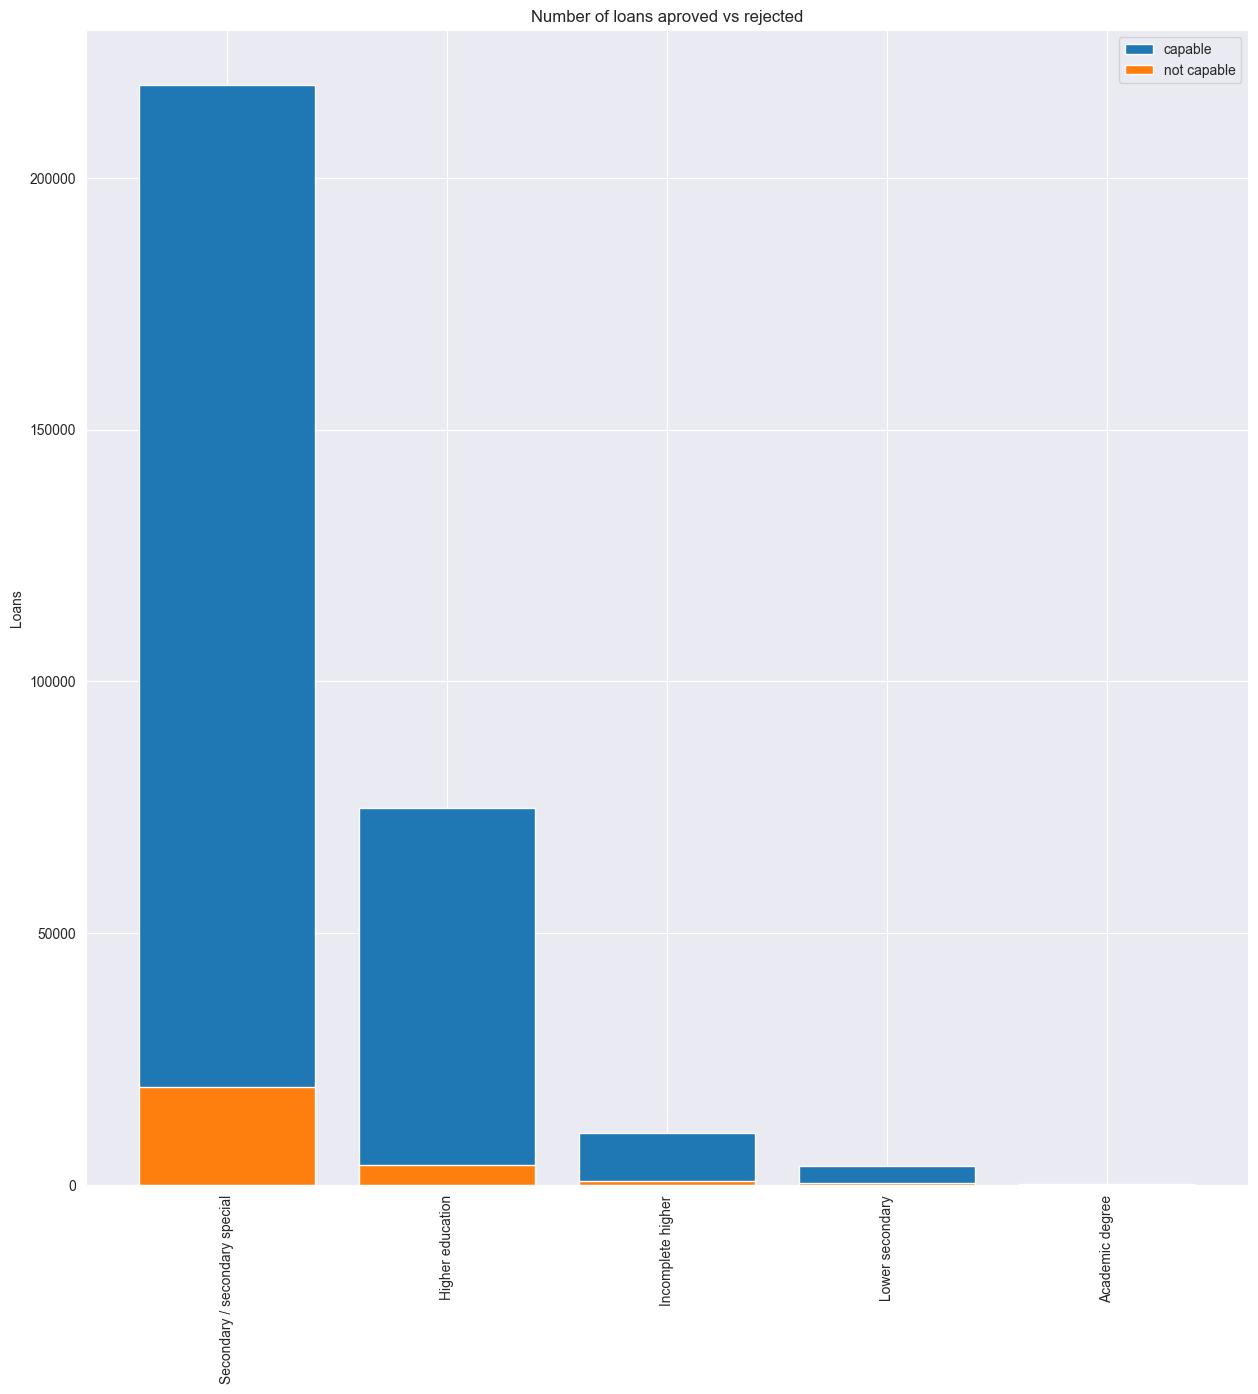

             NAME_EDUCATION_TYPE  TARGET   total       Avg
4  Secondary / secondary special   19524  218391  0.089399
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
0                Academic degree       3     164  0.018293
             NAME_EDUCATION_TYPE  TARGET   total       Avg
4  Secondary / secondary special   19524  218391  0.089399
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
0                Academic degree       3     164  0.018293


In [33]:
train_data['NAME_EDUCATION_TYPE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'NAME_EDUCATION_TYPE', 'TARGET', False)

**Kết luận rút ra:**
Độ phổ biến:
* Nhóm “Secondary / secondary special” (tốt nghiệp PTTH hoặc tương đương) chiếm đa số (>70%).
* Các nhóm khác (“Higher education”, “Incomplete higher”, “Lower secondary”, “Academic degree”) lần lượt nhỏ hơn nhiều.

Tỷ lệ vỡ nợ:
* “Lower secondary” (PTCS) có tỷ lệ cao nhất ~10.9%.
* “Higher education” (đại học trở lên) thấp nhất ~5.4%.
* “Academic degree” (thạc sĩ/tiến sĩ) rất ít data nhưng tỷ lệ vỡ nợ cực thấp ~1.8%.
* “Secondary / secondary special” mặc dù đông nhất nhưng chỉ ~8.9% vỡ nợ—chênh không quá lớn so với các nhóm khác (ngoại trừ nhóm học vấn cao hơn).

Độ biến động:
* Khoảng cách giữa nhóm “Lower secondary” và “Academic degree” khá lớn (~1.8% vs 10.9%), nhưng vì số lượng nhóm nhỏ quá ít nên cần thận trọng.

### 2.3.15 Univariate Analysis : Name_Housing_Type

In [34]:
train_data['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

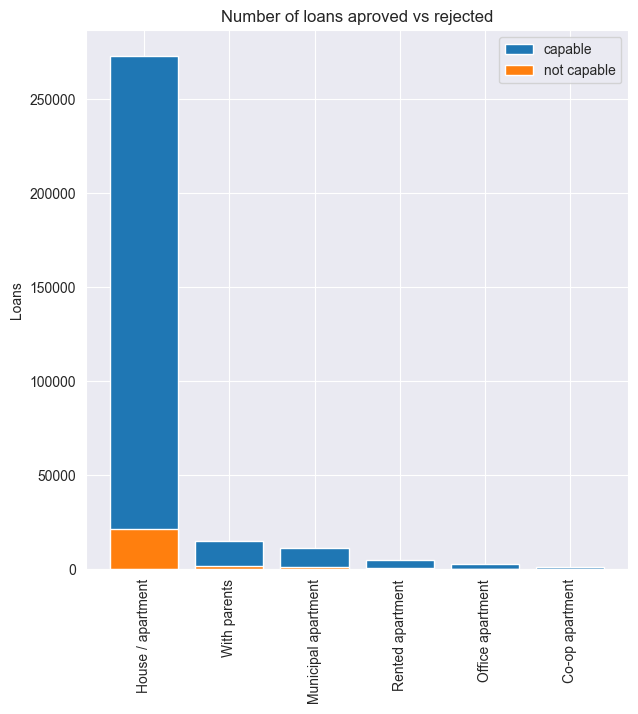

     NAME_HOUSING_TYPE  TARGET   total       Avg
1    House / apartment   21272  272868  0.077957
5         With parents    1736   14840  0.116981
2  Municipal apartment     955   11183  0.085397
4     Rented apartment     601    4881  0.123131
3     Office apartment     172    2617  0.065724
     NAME_HOUSING_TYPE  TARGET  total       Avg
5         With parents    1736  14840  0.116981
2  Municipal apartment     955  11183  0.085397
4     Rented apartment     601   4881  0.123131
3     Office apartment     172   2617  0.065724
0      Co-op apartment      89   1122  0.079323


In [35]:
train_data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'NAME_HOUSING_TYPE', 'TARGET', False)

**Kết luận rut ra:**
* Đa số khách sống tại House / apartment, với ~7.8% vỡ nợ.
* Tỷ lệ vỡ nợ cao nhất ở nhóm Rented apartment (~12.3%), tiếp theo là With parents (~11.7%).
* Nhóm Office apartment có tỷ lệ thấp nhất (~6.6%).
* Variability đáng kể: chênh lệch giữa nhóm “thuê” và “căn hộ công ty” hơn 5%.

### 2.3.16 Univariate Analysis : Days_Birth

In [36]:
capable_days_birth = train_data[train_data['TARGET']==0]['DAYS_BIRTH'].values/365
not_capable_days_birth = train_data[train_data['TARGET']==1]['DAYS_BIRTH'].values/365

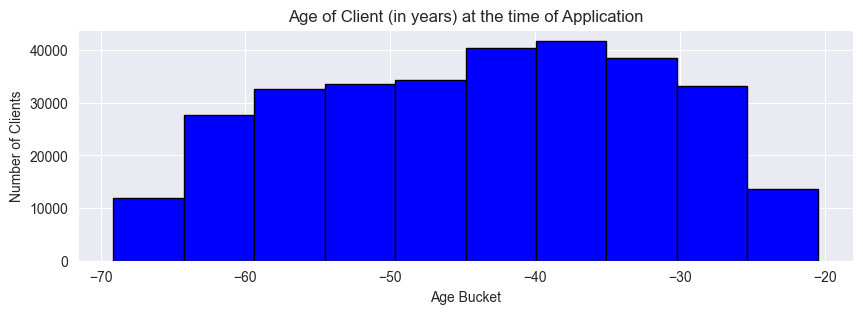

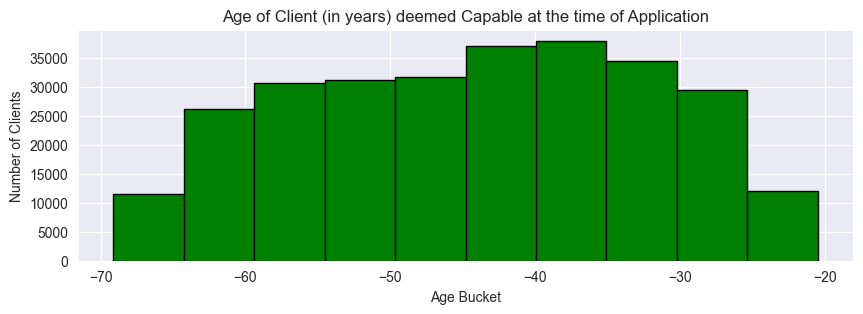

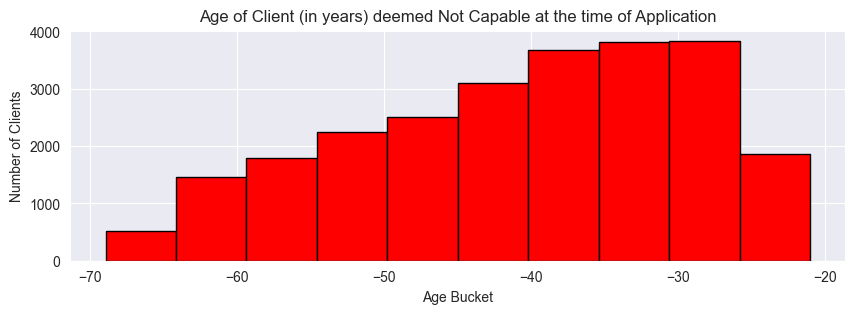

In [37]:
plt.figure(figsize=(10,3))
plt.hist(train_data['DAYS_BIRTH'].values/365, bins=10, edgecolor='black', color='blue')
plt.title('Age of Client (in years) at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(capable_days_birth, bins=10, edgecolor='black', color='green')
plt.title('Age of Client (in years) deemed Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(not_capable_days_birth, bins=10, edgecolor='black', color='red')
plt.title('Age of Client (in years) deemed Not Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Đa số hồ sơ thuộc độ tuổi 35–45, cả hai nhóm đều đông nhất ở đây.
* Tỷ lệ trả được nợ cao nhất cũng rơi vào khách hàng 35–45 tuổi.
* Khách trẻ (25–35) gặp tỉ lệ “not capable” tương đối cao hơn; có thể do kinh nghiệm đi làm, mức thu nhập còn thấp hoặc thời gian ổn định nghề nghiệp chưa dài.
* Khách ngoài nhóm chính (<25, >65) rất ít nên ít ảnh hưởng đến model, nhưng bạn vẫn có thể gom chung vào một bucket “rare_age” nếu muốn.



### 2.3.17 Univariate Analysis : Days_Employed

In [38]:
capable_days_employed = train_data[train_data['TARGET']==0]['DAYS_EMPLOYED'].values/365
not_capable_days_employed = train_data[train_data['TARGET']==1]['DAYS_EMPLOYED'].values/365

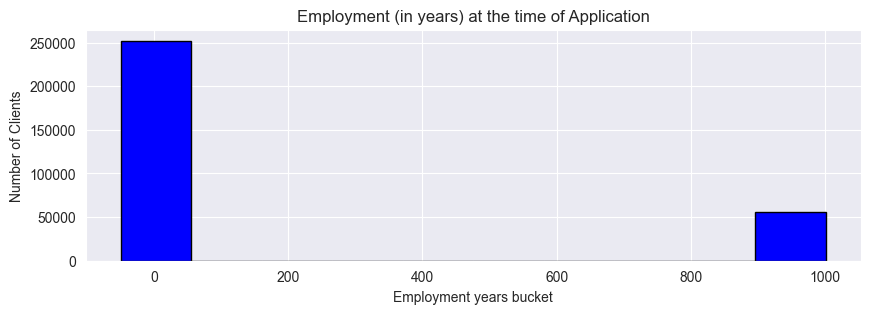

In [39]:
plt.figure(figsize=(10,3))
plt.hist(train_data['DAYS_EMPLOYED'].values/365, bins=10, edgecolor='black', color='blue')
plt.title('Employment (in years) at the time of Application')
plt.xlabel('Employment years bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luân rút ra:**
Phát hiện outlier
* Quan sát vào histogram (hoặc in ra train_data['DAYS_EMPLOYED'].unique()), sẽ thấy có giá trị tương đương 365243 ngày (~1000 năm) cho một số dòng.
* Đây không thể là tuổi nghề thật, mà là placeholder dùng trong bộ dữ liệu Home Credit để chỉ “missing”/“anomaly”.

### 2.3.18 Univariate Analysis: Days_Registration

In [40]:
capable_days_registration = train_data[train_data['TARGET']==0]['DAYS_REGISTRATION'].values
not_capable_days_registration = train_data[train_data['TARGET']==1]['DAYS_REGISTRATION'].values

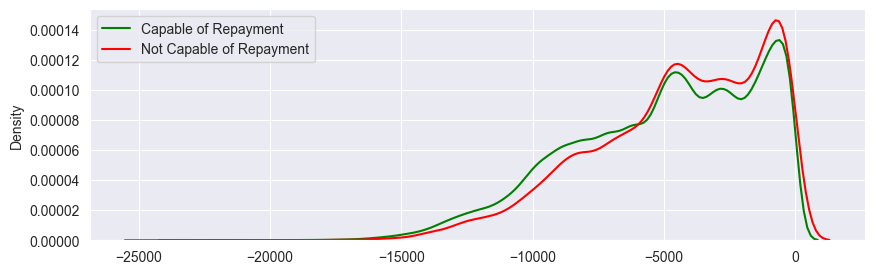

In [41]:
plt.figure(figsize=(10,3))
sns.distplot(capable_days_registration,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_days_registration,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Hầu hết khách hàng đều thay đổi đăng ký dưới 15.000 ngày (tức trong 41 năm gần đây).
* Phần lớn thậm chí dưới 5.000 ngày (13 năm), cho thấy ít người giữ nguyên đăng ký quá lâu trước khi vay.
* Nếu phân biệt rõ hai đường màu xanh/đỏ, bạn có thể kiểm tra xem nhóm nào có xu hướng giữ đăng ký “mới” hay “cũ” hơn—điều này có thể liên quan đến tính ổn định chỗ ở và rủi ro tín dụng.

### 2.3.19 Univariate Analysis: Days_ID_Publish

In [42]:
# Số ngày trước ngày nộp đơn mà khách hàng đã thay đổi giấy tờ tùy thân dùng để nộp đơn xin vay.

In [43]:
capable_days_id_publish = train_data[train_data['TARGET']==0]['DAYS_ID_PUBLISH'].values
not_capable_days_id_publish = train_data[train_data['TARGET']==1]['DAYS_ID_PUBLISH'].values

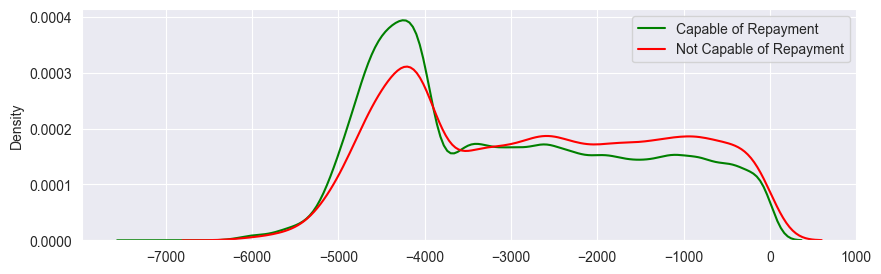

In [44]:
plt.figure(figsize=(10,3))
sns.distplot(capable_days_id_publish,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_days_id_publish,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Hầu hết khách hàng đã thay đổi giấy tờ tùy thân của mình khoảng 4000 ngày (10,95 năm) trước ngày nộp đơn.

### 2.3.20 Univariate Analysis: Own_Car_Age

In [45]:
capable_car_age = train_data[train_data['TARGET']==0]['OWN_CAR_AGE'].values
not_capable_car_age = train_data[train_data['TARGET']==1]['OWN_CAR_AGE'].values

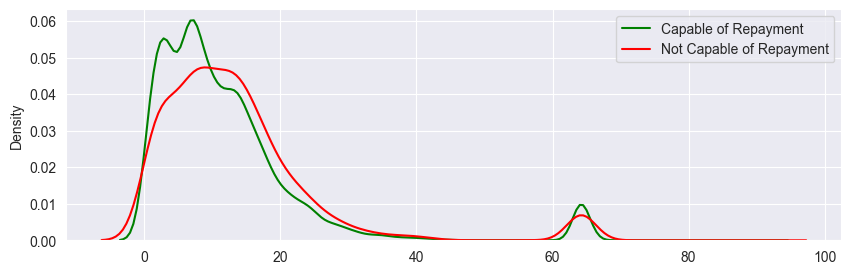

In [46]:
plt.figure(figsize=(10,3))
sns.distplot(capable_car_age,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_car_age,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Hầu hết khách hàng đều có xe ô tô dưới 20 năm tuổi trong khi rất ít xe ô tô có tuổi đời trên 20 năm.

### 2.3.21 Univariate Analysis: Flag_Mobil

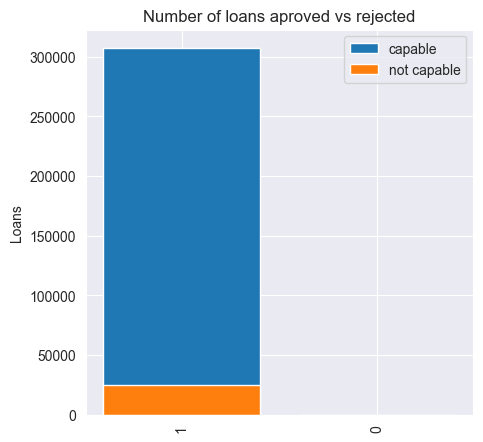

   FLAG_MOBIL  TARGET   total       Avg
1           1   24825  307510  0.080729
0           0       0       1  0.000000
   FLAG_MOBIL  TARGET   total       Avg
1           1   24825  307510  0.080729
0           0       0       1  0.000000


In [47]:
train_data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'FLAG_MOBIL', 'TARGET', False)

**Kết luận rút ra:**
* Trong tổng số 307511 đơn xin vay trong Train Data, gần như tất cả mọi người trong đơn đều sở hữu Điện thoại di động, trong đó 92% được coi là có khả năng và 8% được coi là không có khả năng

### 2.3.22 Univariate Analysis: Flag_Emp_Phone

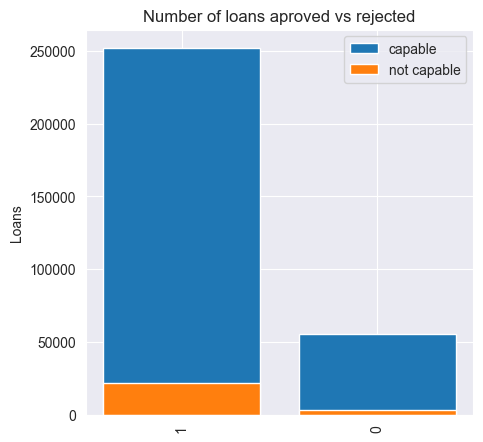

   FLAG_EMP_PHONE  TARGET   total       Avg
1               1   21834  252125  0.086600
0               0    2991   55386  0.054003
   FLAG_EMP_PHONE  TARGET   total       Avg
1               1   21834  252125  0.086600
0               0    2991   55386  0.054003


In [48]:
train_data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'FLAG_EMP_PHONE', 'TARGET', False)

**Kết luận rút ra:**
* Nhiều ứng viên cung cấp số điện thoại công việc (83%) so với những ứng viên không cung cấp số điện thoại công việc (17%).

### 2.3.23. Univariate Analysis: Flag_Cont_Mobile

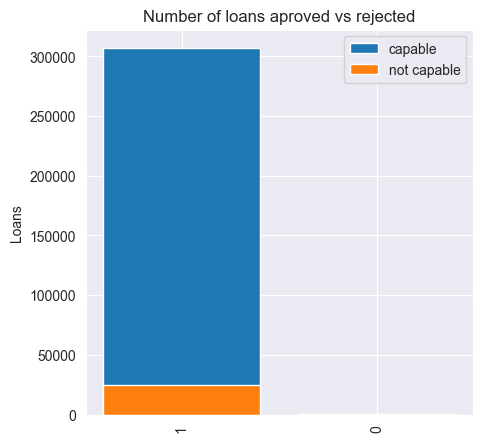

   FLAG_CONT_MOBILE  TARGET   total       Avg
1                 1   24780  306937  0.080733
0                 0      45     574  0.078397
   FLAG_CONT_MOBILE  TARGET   total       Avg
1                 1   24780  306937  0.080733
0                 0      45     574  0.078397


In [49]:
train_data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'FLAG_CONT_MOBILE', 'TARGET', False)

**Kết luận rút ra:**
* 99% người nộp đơn có thể liên lạc được qua điện thoại khi Ngân hàng cố gắng liên lạc với họ

### 2.3.24 Univariate Analysis: Flag_Email

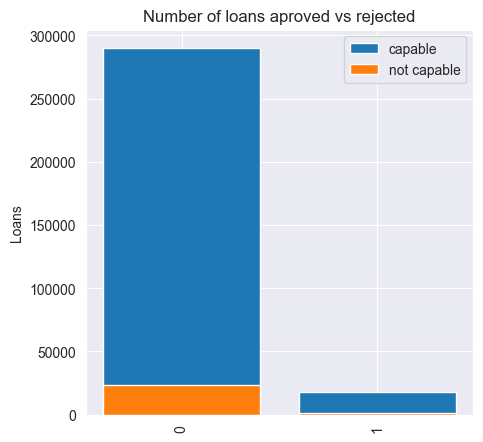

   FLAG_EMAIL  TARGET   total       Avg
0           0   23451  290069  0.080846
1           1    1374   17442  0.078775
   FLAG_EMAIL  TARGET   total       Avg
0           0   23451  290069  0.080846
1           1    1374   17442  0.078775


In [50]:
train_data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'FLAG_EMAIL', 'TARGET', False)

**Kết luận rút ra:**
* Điều này cho thấy rằng khoảng 94% khách hàng không cung cấp Địa chỉ Email của họ trong đơn đăng ký và chỉ có 6% khách hàng cung cấp thông tin chi tiết về Email.

### 2.3.25. Univariate Analysis: Occupation_Type

In [51]:
train_data['OCCUPATION_TYPE'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

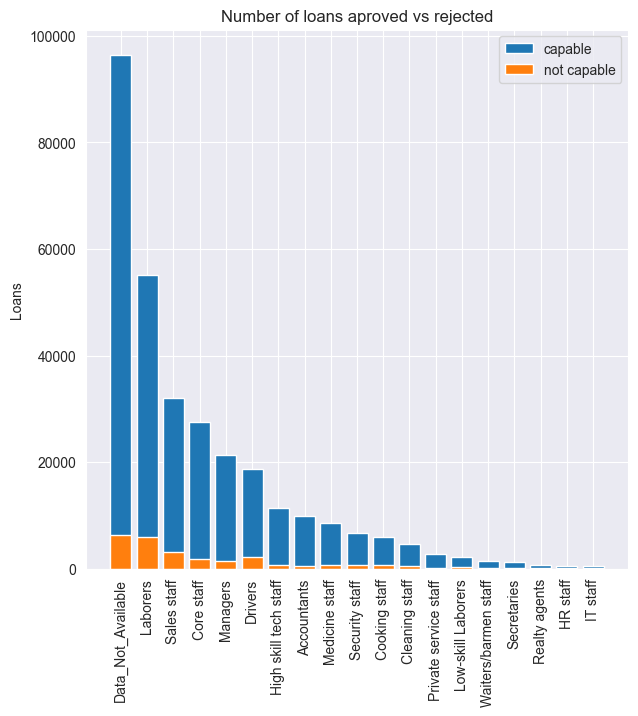

       OCCUPATION_TYPE  TARGET  total       Avg
4   Data_Not_Available    6278  96391  0.065131
9             Laborers    5838  55186  0.105788
15         Sales staff    3092  32102  0.096318
3           Core staff    1738  27570  0.063040
11            Managers    1328  21371  0.062140
         OCCUPATION_TYPE  TARGET  total       Avg
18  Waiters/barmen staff     152   1348  0.112760
16           Secretaries      92   1305  0.070498
14         Realty agents      59    751  0.078562
6               HR staff      36    563  0.063943
8               IT staff      34    526  0.064639


In [52]:
train_data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)
univariate_barplots(train_data, 'OCCUPATION_TYPE', 'TARGET', False)

**Kết luận rút ra:**
* Missing chiếm đa số (~31% ứng viên không khai nghề).
* Trong số người có nghề, Laborers (công nhân phổ thông) chiếm ~18% và có tỷ lệ vỡ nợ ~10.6%.
* Sales staff cũng nhiều (~10%) và vỡ nợ ~9.6%.
* Waiters/barmen staff dù ít (~ 1,3k hồ sơ) nhưng có tỷ lệ vỡ nợ cao nhất (~ 11.3%).
* Các nghề như Managers, Core staff, HR, IT có tỷ lệ vỡ nợ thấp (~6%).

### 2.3.26 Univariate Analysis: Cnt_Fam_Members

In [53]:
train_data['CNT_FAM_MEMBERS'].isnull().sum()

np.int64(2)

In [54]:
#Replace NA with the most frequently occuring class for Count of Client Family Members
train_data['CNT_FAM_MEMBERS'].fillna(train_data['CNT_FAM_MEMBERS'].value_counts().idxmax(), \
                                     inplace=True)

In [55]:
capable_family_members = train_data[train_data['TARGET']==0]['CNT_FAM_MEMBERS'].values
not_capable_family_members = train_data[train_data['TARGET']==1]['CNT_FAM_MEMBERS'].values

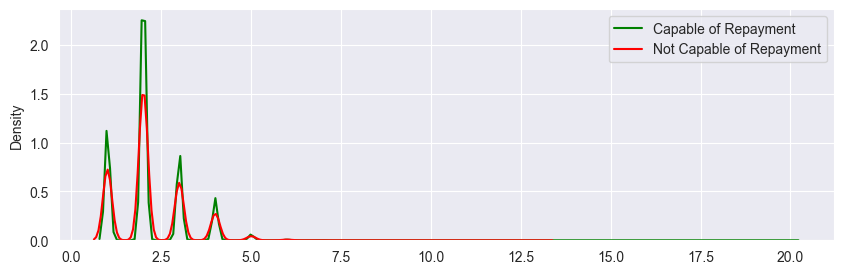

In [56]:
plt.figure(figsize=(10,3))
sns.distplot(capable_family_members,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_family_members,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Hầu hết các ứng viên đều có 2 Thành viên gia đình và rất ít ứng viên có >5 thành viên gia đình.


### 2.3.27 Univariate Analysis: Weekday_Appr_Process_Start

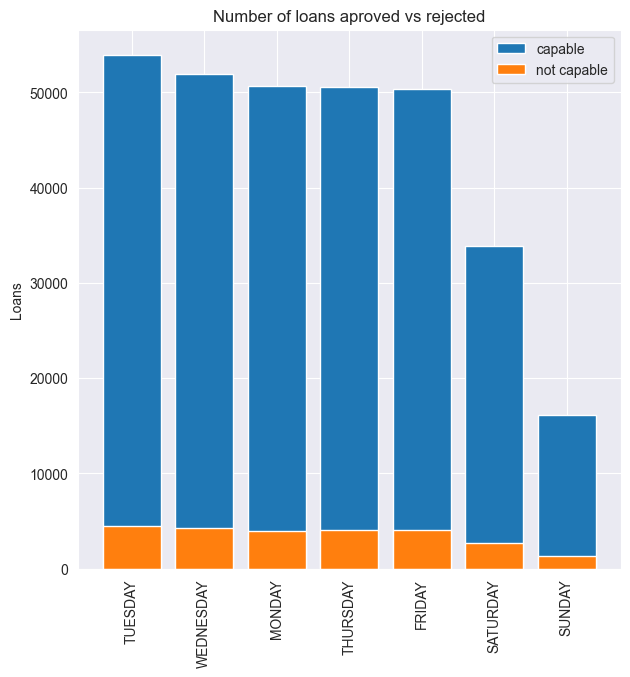

  WEEKDAY_APPR_PROCESS_START  TARGET  total       Avg
5                    TUESDAY    4501  53901  0.083505
6                  WEDNESDAY    4238  51934  0.081604
1                     MONDAY    3934  50714  0.077572
4                   THURSDAY    4098  50591  0.081003
0                     FRIDAY    4101  50338  0.081469
  WEEKDAY_APPR_PROCESS_START  TARGET  total       Avg
1                     MONDAY    3934  50714  0.077572
4                   THURSDAY    4098  50591  0.081003
0                     FRIDAY    4101  50338  0.081469
2                   SATURDAY    2670  33852  0.078873
3                     SUNDAY    1283  16181  0.079291


In [57]:
univariate_barplots(train_data, 'WEEKDAY_APPR_PROCESS_START', 'TARGET', False)

**Kết luân rút ra:**
* Số lượng đơn đăng ký được phân bổ gần như đồng đều trong suốt các ngày trong tuần (Thứ Hai-Thứ Sáu) (khoảng 50.000 đơn đăng ký mỗi ngày) (16-17%), trong khi số lượng đơn đăng ký rất thấp vào Chủ Nhật.

### 2.3.28 Univariate Analysis: Organization_Type

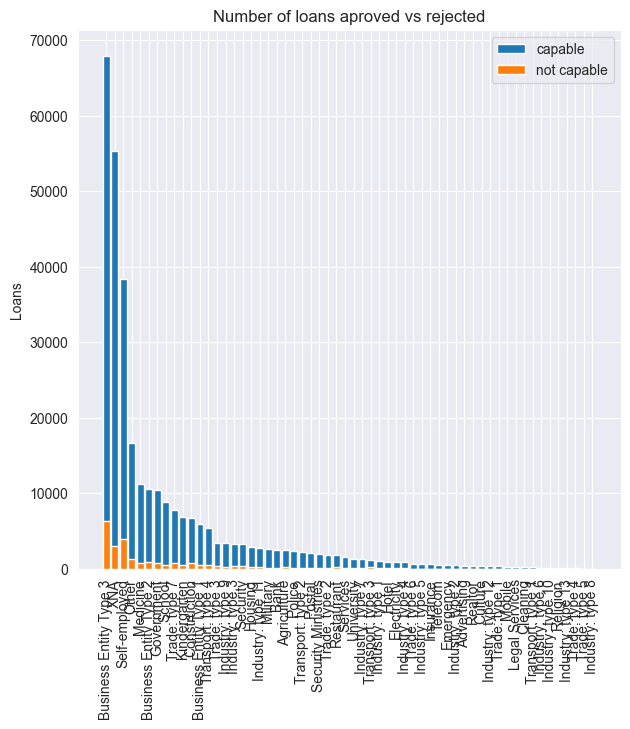

         ORGANIZATION_TYPE  TARGET  total       Avg
5   Business Entity Type 3    6323  67992  0.092996
57                     XNA    2990  55374  0.053996
42           Self-employed    3908  38412  0.101739
33                   Other    1275  16683  0.076425
30                Medicine     737  11193  0.065845
    ORGANIZATION_TYPE  TARGET  total       Avg
37           Religion       5     85  0.058824
18  Industry: type 13       9     67  0.134328
48      Trade: type 4       2     64  0.031250
49      Trade: type 5       3     49  0.061224
25   Industry: type 8       3     24  0.125000


In [58]:
univariate_barplots(train_data, 'ORGANIZATION_TYPE', 'TARGET', False)

**Kết luận rút ra:**
* Doanh nhân và XNA (Không cung cấp thông tin) có số lượng ứng viên cao nhất nhưng Doanh nhân và người tự kinh doanh lại có tỷ lệ vỡ nợ cao nhất.

### 2.3.29 Univariate Analysis: EXT_SOURCE_1

In [59]:
train_data['EXT_SOURCE_1'].isnull().sum()

np.int64(173378)

In [60]:
capable_ext_source_1 = train_data[train_data['TARGET']==0]['EXT_SOURCE_1'].values
not_capable_ext_source_1 = train_data[train_data['TARGET']==1]['EXT_SOURCE_1'].values

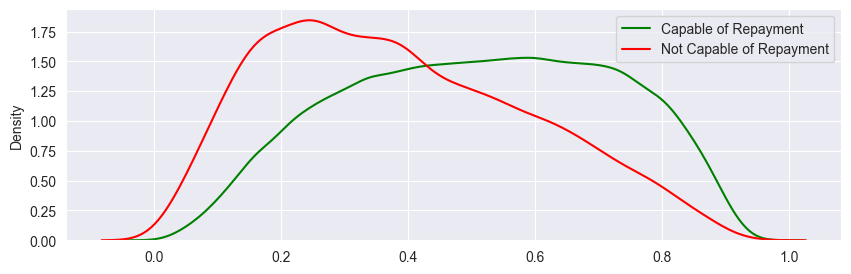

In [61]:
plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_1,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_1,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Có sự khác biệt giữa 2 lớp
* Do đó, EXT_SOURECE_1 có thể là 1 feature quan trọng

### 2.3.30. Univariate Analysis: EXT_SOURCE_2

In [62]:
train_data['EXT_SOURCE_2'].isnull().sum() # 0.2% null

np.int64(660)

In [63]:
capable_ext_source_2 = train_data[train_data['TARGET']==0]['EXT_SOURCE_2'].values
not_capable_ext_source_2 = train_data[train_data['TARGET']==1]['EXT_SOURCE_2'].values

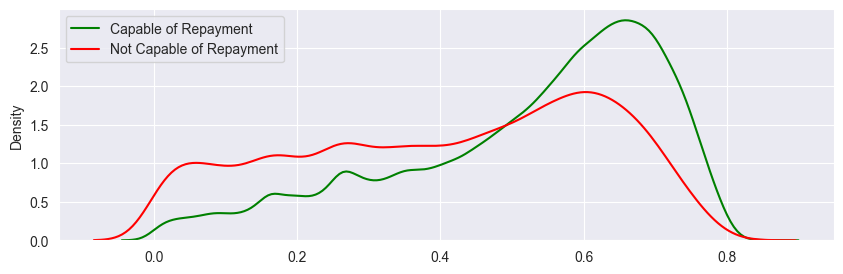

In [64]:
plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_2,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_2,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Có sự khác biệt giữa 2 lớp
* Do đó, EXT_SOURECE_2 có thể là 1 feature quan trọng

### 2.3.31. Univariate Analysis: EXT_SOURCE_3

In [65]:
train_data['EXT_SOURCE_3'].isnull().sum() # 19% null

np.int64(60965)

In [66]:
capable_ext_source_3 = train_data[train_data['TARGET']==0]['EXT_SOURCE_3'].values
not_capable_ext_source_3 = train_data[train_data['TARGET']==1]['EXT_SOURCE_3'].values

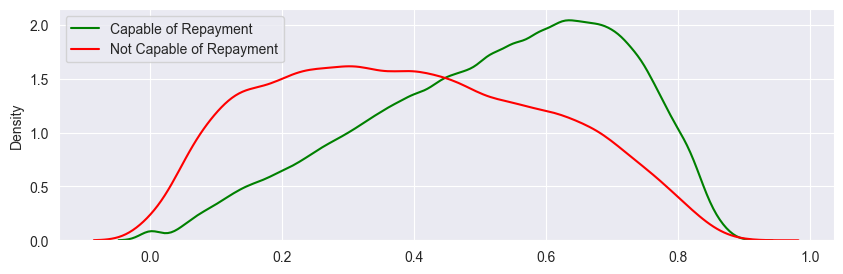

In [67]:
plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_3,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_3,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

**Kết luận rút ra:**
* Có sự khác biệt giữa 2 lớp
* Do đó, EXT_SOURECE_3 có thể là 1 feature quan trọng

### 2.3.32 Univariate Analysis: Flag_Document_x

In [68]:
flag_document_df = train_data.loc[:, train_data.columns.str.contains('DOCUMENT')]
flag_document_df.head(5)

,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
for column in flag_document_df:

    count_0 = flag_document_df[column].value_counts()[0]
    count_1 = flag_document_df[column].value_counts()[1]
    total_rows = flag_document_df.shape[0]

    percent_0 = np.round((count_0*100/total_rows),2)
    percent_1 = np.round(100 - percent_0,2)

    print(column, "contains percentage of 1's = ",percent_1,\
    "and percentage of 0's =", percent_0)

FLAG_DOCUMENT_2 contains percentage of 1's =  0.0 and percentage of 0's = 100.0
FLAG_DOCUMENT_3 contains percentage of 1's =  71.0 and percentage of 0's = 29.0
FLAG_DOCUMENT_4 contains percentage of 1's =  0.01 and percentage of 0's = 99.99
FLAG_DOCUMENT_5 contains percentage of 1's =  1.51 and percentage of 0's = 98.49
FLAG_DOCUMENT_6 contains percentage of 1's =  8.81 and percentage of 0's = 91.19
FLAG_DOCUMENT_7 contains percentage of 1's =  0.02 and percentage of 0's = 99.98
FLAG_DOCUMENT_8 contains percentage of 1's =  8.14 and percentage of 0's = 91.86
FLAG_DOCUMENT_9 contains percentage of 1's =  0.39 and percentage of 0's = 99.61
FLAG_DOCUMENT_10 contains percentage of 1's =  0.0 and percentage of 0's = 100.0
FLAG_DOCUMENT_11 contains percentage of 1's =  0.39 and percentage of 0's = 99.61
FLAG_DOCUMENT_12 contains percentage of 1's =  0.0 and percentage of 0's = 100.0
FLAG_DOCUMENT_13 contains percentage of 1's =  0.35 and percentage of 0's = 99.65
FLAG_DOCUMENT_14 contains pe

**Kết luận rút ra:**
* Flag_Document_3 là 1 feauture có ảnh hưởng tốt

### 2.3.33 Bivariate Analysis: NAME_CONTRACT_TYPE vs AMT_CREDIT

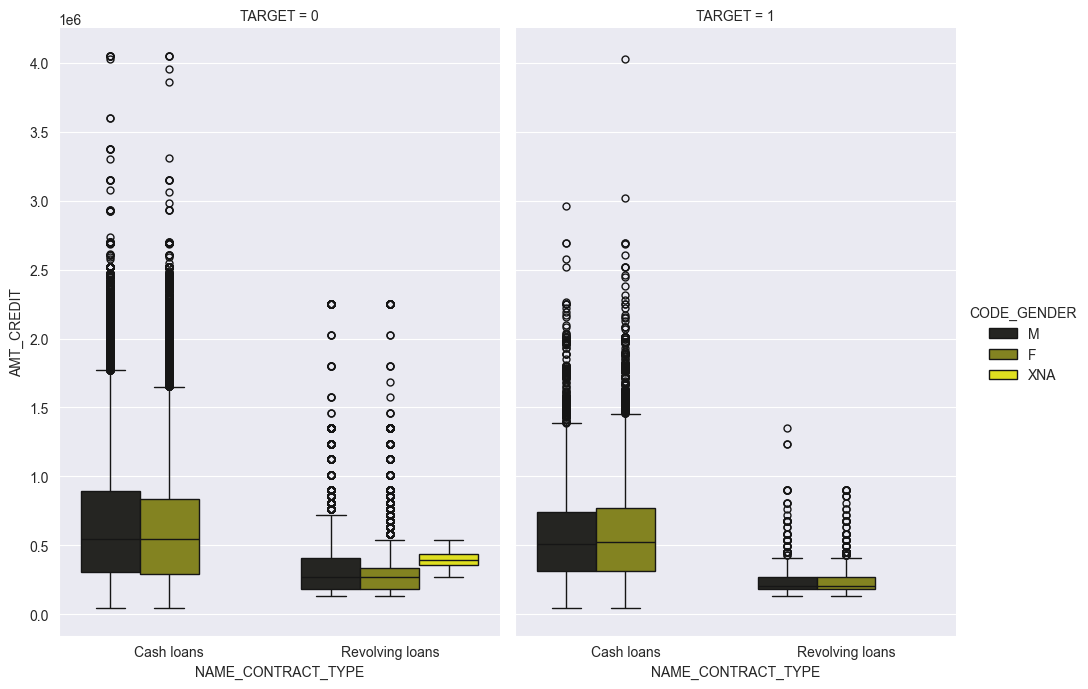

In [70]:
sns.catplot(x="NAME_CONTRACT_TYPE", y="AMT_CREDIT", hue="CODE_GENDER" ,col="TARGET",\
            data=train_data,color = "yellow",kind="box", height=7, aspect=.7);

**Kết luận rút ra:**
* Điều này cho thấy rằng Nam và Nữ có khoản vay tiền mặt có nhiều khả năng được coi là có khả năng trả nợ dựa trên Số tiền tín dụng của họ.

### 2.3.34 Bivariate Analysis: AMT_CREDIT vs NAME_INCOME_TYPE

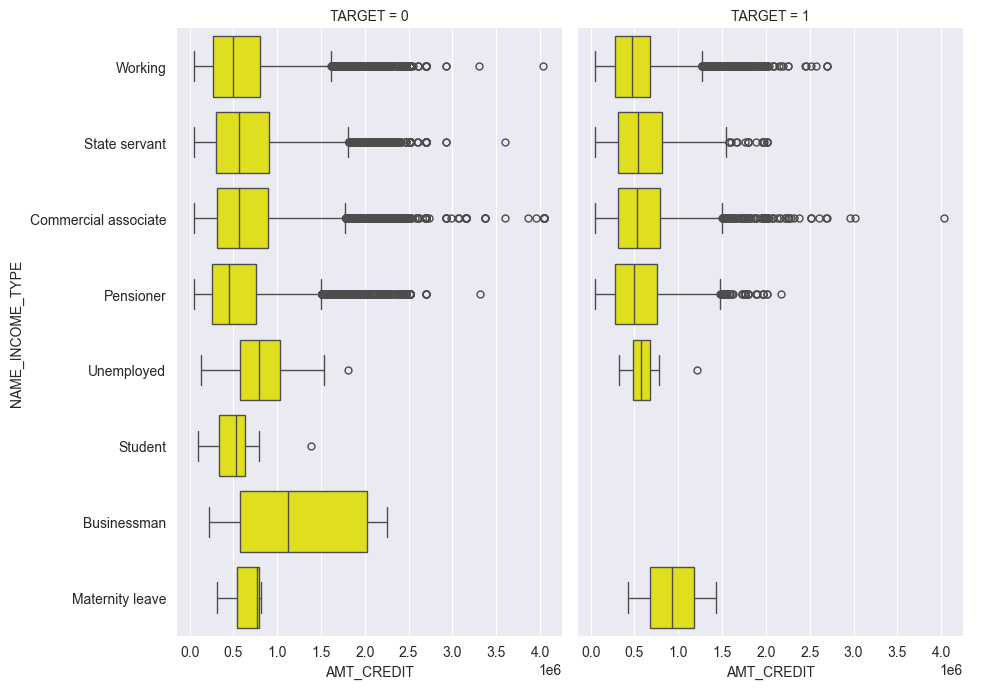

In [71]:
sns.catplot(x="AMT_CREDIT", y="NAME_INCOME_TYPE", col="TARGET",\
            data=train_data,color = "yellow",kind="box", height=7, aspect=.7);

**Kết luận rút ra:**
* Đặc biệt rõ ở các nhóm ít dữ liệu như Unemployed, Student, Businessman:
* Trong nhóm “Unemployed”, dù ít hồ sơ, box của trả được thường cao hơn box của không trả được, nghĩa là người thất nghiệp nếu vay được khoản tương đối lớn thì khả năng trả nợ cũng cao hơn.
* Tương tự với “Student” và “Businessman”: median và IQR của người trả được dịch sang phải.

### 2.3.35 Bivariate Analysis: AMT_CREDIT vs AMT_ANNUITY

<Axes: xlabel='AMT_CREDIT', ylabel='AMT_ANNUITY'>

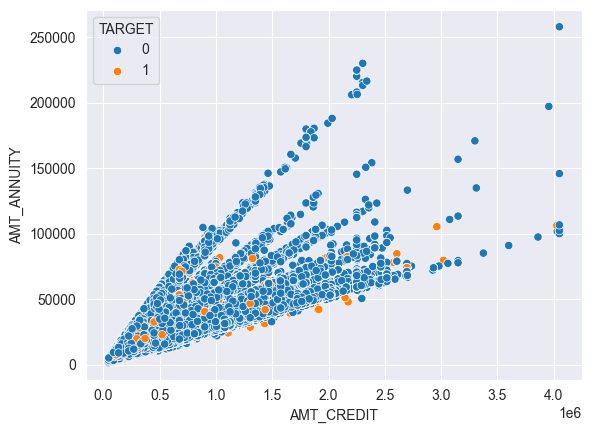

In [72]:
sns.scatterplot(
    data=train_data, x="AMT_CREDIT", y="AMT_ANNUITY", hue="TARGET",\
    sizes=(20, 200)
)

**Kết luận rút ra:**
* Khoản vay càng lớn thì annuity càng lớn.
* Hai biến này gần như tuyệt đối tương quan (phổ hệ số tương quan rất cao).

## 2.4 Fixing Null Values and Outliers

### 2.4.1 Days_Birth

In [73]:
print("The shape of the train dataset = ",train_data.shape)
train_data['DAYS_BIRTH'].describe()

The shape of the train dataset =  (307511, 122)


count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [74]:
print("The maximum age across all applicants (in years) = ",\
      - min(train_data['DAYS_BIRTH'].values)/365)

print("The minimum age across all applicants (in years) = ",\
      - max(train_data['DAYS_BIRTH'].values)/365)

The maximum age across all applicants (in years) =  69.12054794520547
The minimum age across all applicants (in years) =  20.517808219178082


### 2.4.1 Days_Employed

In [75]:
train_data['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [76]:
print("The minimum employment across all applicants (in years) = ",\
        max(train_data['DAYS_EMPLOYED'].values)/365)

print("The maximum employment across all applicants (in years) = ",\
        min(train_data['DAYS_EMPLOYED'].values)/365)

The minimum employment across all applicants (in years) =  1000.6657534246575
The maximum employment across all applicants (in years) =  -49.07397260273972


In [77]:
train_data.replace(max(train_data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

### 2.4.3 Days_Registration

In [78]:
train_data['DAYS_REGISTRATION'].describe()

count    307511.0
mean          NaN
std           0.0
min      -24672.0
25%       -7480.0
50%       -4504.0
75%       -2010.0
max           0.0
Name: DAYS_REGISTRATION, dtype: float64

In [79]:
print("The minimum days of registration across all applicants (in years) = ",\
        max(train_data['DAYS_EMPLOYED'].values)/365)

print("The maximum days of registration across all applicants (in years) = ",\
        min(train_data['DAYS_EMPLOYED'].values)/365)

The minimum days of registration across all applicants (in years) =  0.0
The maximum days of registration across all applicants (in years) =  -49.07397260273972


### 2.4.4 Removing Outliers and Null Values

In [80]:
def fix_nulls_outliers(data):

    data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
    data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    #Replace NA with the most frequently occuring class for Count of Client Family Members
    data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].value_counts().idxmax(), \
                                             inplace=True)

    data.replace(max(data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

    data['CODE_GENDER'].replace('XNA','M',inplace=True)
    #There are a total of 4 applicants with Gender provided as 'XNA'

    data['AMT_ANNUITY'].fillna(0, inplace=True)
    #A total of 36 datapoints are there where Annuity Amount is null.

    data['AMT_GOODS_PRICE'].fillna(0, inplace=True)
    #A total of 278 datapoints are there where Annuity Amount is null.

    data['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace=True)
    #Removing datapoints where 'Name_Type_Suite' is null.

    data['NAME_FAMILY_STATUS'].replace('Unknown','Married', inplace=True)
    #Removing datapoints where 'Name_Family_Status' is Unknown.

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['EXT_SOURCE_1'].fillna(0, inplace=True)
    data['EXT_SOURCE_2'].fillna(0, inplace=True)
    data['EXT_SOURCE_3'].fillna(0, inplace=True)

    return data

In [81]:
train_data = fix_nulls_outliers(train_data)
train_data.shape

(307511, 122)

In [82]:
def FE_application_data(data):

    data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['CREDIT_ANNUITY_PERCENT'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']

    data['FAMILY_CNT_INCOME_PERCENT'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['BIRTH_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['CHILDREN_CNT_INCOME_PERCENT'] = data['AMT_INCOME_TOTAL']/data['CNT_CHILDREN']

    data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
    data['EMPLOYED_REGISTRATION_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_REGISTRATION']
    data['BIRTH_REGISTRATION_PERCENT'] = data['DAYS_BIRTH'] / data['DAYS_REGISTRATION']
    data['ID_REGISTRATION_DIFF'] = data['DAYS_ID_PUBLISH'] - data['DAYS_REGISTRATION']

    data['ANNUITY_LENGTH_EMPLOYED_PERCENT'] = data['CREDIT_TERM']/ data['DAYS_EMPLOYED']

    data['AGE_LOAN_FINISH'] = data['DAYS_BIRTH']*(-1.0/365) + \
                         (data['AMT_CREDIT']/data['AMT_ANNUITY']) *(1.0/12)
    # (This basically refers to the client's age when he/she finishes loan repayment)

    data['CAR_AGE_EMP_PERCENT'] = data['OWN_CAR_AGE']/data['DAYS_EMPLOYED']
    data['CAR_AGE_BIRTH_PERCENT'] = data['OWN_CAR_AGE']/data['DAYS_BIRTH']
    data['PHONE_CHANGE_EMP_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_EMPLOYED']
    data['PHONE_CHANGE_BIRTH_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_BIRTH']

    income_by_contract = data[['AMT_INCOME_TOTAL', 'NAME_CONTRACT_TYPE']].groupby('NAME_CONTRACT_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_CONTRACT_TYPE'] = data['NAME_CONTRACT_TYPE'].map(income_by_contract)

    income_by_suite = data[['AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE']].groupby('NAME_TYPE_SUITE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_SUITE_TYPE'] = data['NAME_TYPE_SUITE'].map(income_by_suite)

    income_by_housing = data[['AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE']].groupby('NAME_HOUSING_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_HOUSING_TYPE'] = data['NAME_HOUSING_TYPE'].map(income_by_housing)

    income_by_org = data[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_ORG_TYPE'] = data['ORGANIZATION_TYPE'].map(income_by_org)

    income_by_occu = data[['AMT_INCOME_TOTAL', 'OCCUPATION_TYPE']].groupby('OCCUPATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_OCCU_TYPE'] = data['OCCUPATION_TYPE'].map(income_by_occu)

    income_by_education = data[['AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE']].groupby('NAME_EDUCATION_TYPE').median()['AMT_INCOME_TOTAL']
    data['MEDIAN_INCOME_EDU_TYPE'] = data['NAME_EDUCATION_TYPE'].map(income_by_education)

    data['ORG_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_ORG_TYPE']/data['AMT_INCOME_TOTAL']
    data['OCCU_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_OCCU_TYPE']/data['AMT_INCOME_TOTAL']
    data['EDU_TYPE_INCOME_PERCENT'] = data['MEDIAN_INCOME_EDU_TYPE']/data['AMT_INCOME_TOTAL']

    data= data.drop(['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'],axis=1)

    cat_col = [category for category in data.columns if data[category].dtype == 'object']
    data = pd.get_dummies(data, columns= cat_col)

    return data

In [83]:
train_data_temp_1 = FE_application_data(train_data)
print(train_data_temp_1.shape)

(307511, 252)


#### Function to Carry out One Hot Encoding for Categorical Features :-

In [84]:
#Refer :- https://www.kaggle.com/jsaguiar/lightgbm-7th-place-solution
#one hot encode the categorical data

def one_hot_encode(df):
    original_columns = list(df.columns)
    categories = [cat for cat in df.columns if df[cat].dtype == 'object']
    df = pd.get_dummies(df, columns= categories, dummy_na= True) #one_hot_encode the categorical features
    categorical_columns = [cat for cat in df.columns if cat not in original_columns]
    return df, categorical_columns

# 3. Bureau Dataset and Bureau Balance Datasets

## 3.1. Basic Overview of the Bureau Data

In [85]:
import pandas as pd

# Đọc trực tiếp file CSV local (không dùng MinIO)
bureau_data = pd.read_csv(
    '../data/raw/bureau.csv'
)

print("Number of data points : ", bureau_data.shape[0])
print("Number of features    : ", bureau_data.shape[1])

# Nếu bạn có hàm reduce_memory_usage:
bureau_data = reduce_memory_usage(bureau_data)

bureau_data.head()


Number of data points :  1716428
Number of features    :  17
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [86]:
bureau_data.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

## 3.2. Analysis of Bureau Data

### 3.2.1 Univariate Analysis: Credit_Active

In [87]:
from collections import Counter
credit_active_counter = Counter()
for word in bureau_data['CREDIT_ACTIVE'].values:
    credit_active_counter.update(word.split(','))

print(credit_active_counter)

Counter({'Closed': 1079273, 'Active': 630607, 'Sold': 6527, 'Bad debt': 21})


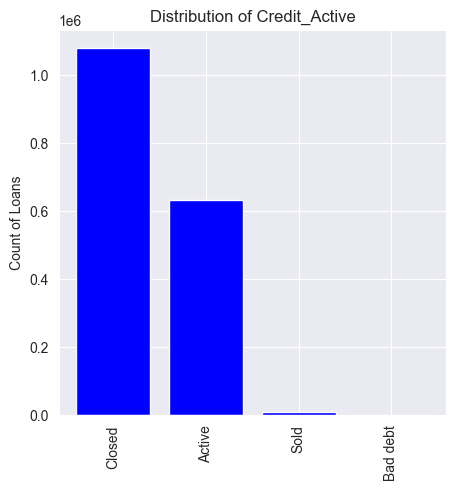

In [88]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
status_dict = dict(credit_active_counter)
sorted_status_dict = dict(sorted(status_dict.items(), key=lambda kv: kv[1], reverse=True))


ind = np.arange(len(sorted_status_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind, list(sorted_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Credit_Active')
plt.xticks(ind, list(sorted_status_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Phần lớn các hồ sơ trong dữ liệu Bureau có trạng thái Closed, tiếp theo là Active.
* Rất ít khoản vay có trạng thái 'Sold' hoặc được xem là 'Bad Debt'

### 3.2.2 Univariate Analysis: Days_Credit

Cột Days_Credit đề cập đến khoảng thời gian (tính bằng ngày) trước khi khách hàng nộp đơn xin Tín dụng Cục.

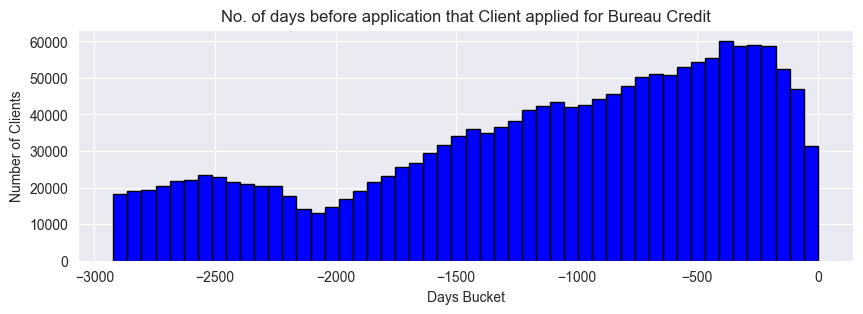

In [89]:
plt.figure(figsize=(10,3))
plt.hist(bureau_data['DAYS_CREDIT'].values, bins=50, edgecolor='black', color='blue')
plt.title('No. of days before application that Client applied for Bureau Credit')
plt.xlabel('Days Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Hầu hết khách hàng nộp đơn xin vay tại Bureau Credit chưa đầy 500 ngày trước ngày nộp đơn xin vay.

### 3.2.3 Univariate Analysis: Credit_Day_Overdue

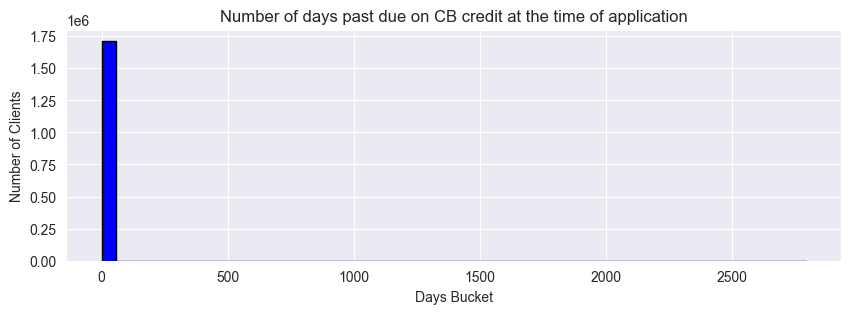

In [90]:
plt.figure(figsize=(10,3))
plt.hist(bureau_data['CREDIT_DAY_OVERDUE'].values, bins=50, edgecolor='black', color='blue')
plt.title('Number of days past due on CB credit at the time of application')
plt.xlabel('Days Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Điều này cho thấy hầu hết khách hàng có DPD thấp (gần 0) trên CB Credit tại thời điểm xét duyệt hồ sơ, vì biểu đồ histogram có đỉnh rất cao gần 0. Để phân tích sâu hơn, chúng ta sẽ xem xét các giá trị phân vị tương ứng như dưới đây.

In [91]:
y = PrettyTable()
y.field_names = ["Percentile", "No. of days past due on CB Credit"]

for i in range(0,101,10):
    y.add_row([i,np.percentile(bureau_data['CREDIT_DAY_OVERDUE'].values,i)])
print(y)

+------------+-----------------------------------+
| Percentile | No. of days past due on CB Credit |
+------------+-----------------------------------+
|     0      |                0.0                |
|     10     |                0.0                |
|     20     |                0.0                |
|     30     |                0.0                |
|     40     |                0.0                |
|     50     |                0.0                |
|     60     |                0.0                |
|     70     |                0.0                |
|     80     |                0.0                |
|     90     |                0.0                |
|    100     |               2792.0              |
+------------+-----------------------------------+


**Kết luận rút ra:**
*  Có giá trị DPD bằng 0 cho đến phân vị 90, trong khi phân vị 100 có giá trị bằng 2792. Chúng ta sẽ tiếp tục phóng to xem các giá trị giữa phân vị 99 và 100.

In [92]:
z = PrettyTable()
z.field_names = ["Percentile", "No. of days past due on CB Credit"]

for i in np.arange(99,100,0.1):
    z.add_row(np.round([i,np.percentile(bureau_data['CREDIT_DAY_OVERDUE'].values,i)],2))
print(z)

+------------+-----------------------------------+
| Percentile | No. of days past due on CB Credit |
+------------+-----------------------------------+
|    99.0    |                0.0                |
|    99.1    |                0.0                |
|    99.2    |                0.0                |
|    99.3    |                0.0                |
|    99.4    |                0.0                |
|    99.5    |                0.0                |
|    99.6    |                0.0                |
|    99.7    |                0.0                |
|    99.8    |                13.0               |
|    99.9    |               52.57               |
+------------+-----------------------------------+


**Kết luận rút ra:**
* Chúng ta có thể thấy từ đây rằng chỉ có 0,3 phần trăm giá trị ở đây là khác không.

In [93]:
bureau_data[bureau_data['CREDIT_DAY_OVERDUE']>0].shape[0]
#This basically shows that there are a total of 4217 datapoints where the 'Credit_Day_Overdue' value is greater
#than 0.

4217

### 3.2.4 Univariate Analysis: Credit_Type

In [94]:
credit_type_counter = Counter()
for type in bureau_data['CREDIT_TYPE'].values:
    credit_type_counter.update(type.split(','))

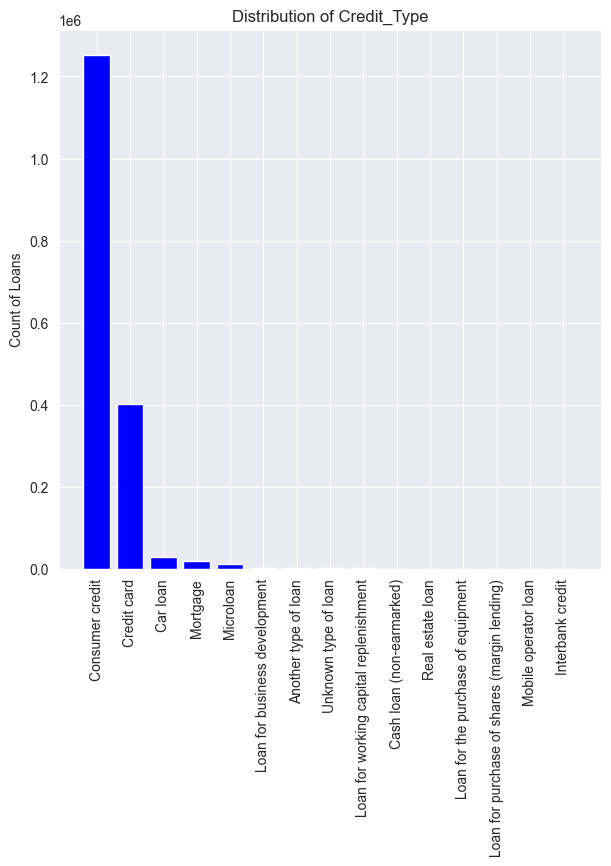

In [95]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
type_dict = dict(credit_type_counter)
sorted_type_dict = dict(sorted(type_dict.items(), key=lambda kv: kv[1], reverse=True))

ind_2 = np.arange(len(sorted_type_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_2, list(sorted_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Credit_Type')
plt.xticks(ind_2, list(sorted_type_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Tín dụng tiêu dùng và Thẻ tín dụng là những loại tín dụng được đăng ký nhiều nhất tại Văn phòng tín dụng.

### 3.2.5 Bivariate Analysis: Credit_Active vs Days_Credit

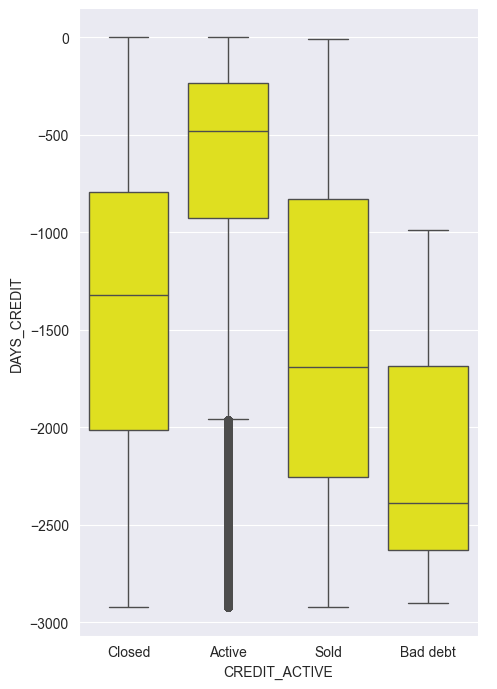

In [96]:
sns.catplot(x="CREDIT_ACTIVE", y="DAYS_CREDIT",\
            data=bureau_data,color = "yellow",kind="box", height=7, aspect=.7);

**Kết luận rút ra:**
* Khi Credit Status là Active, tức số ngày tín dụng (Days_Credit) trước thời điểm nộp hồ sơ có giá trị trung vị khoảng 500 ngày.

## 4.3. Basic Overview of the Bureau Balance Data

In [97]:
import pandas as pd

# Đọc file CSV local
bureau_balance = pd.read_csv('../data/raw/bureau_balance.csv')

print('Number of data points : ', bureau_balance.shape[0])
print('Number of features    : ', bureau_balance.shape[1])

# Giảm memory footprint
bureau_balance = reduce_memory_usage(bureau_balance)

bureau_balance.head()


Number of data points :  27299925
Number of features    :  3
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [98]:
bureau_balance.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

## 3.4. Bureau Balance Data Analysis

### 3.4.1 Univariate Analysis: Status

In [99]:
bureau_status_counter = Counter()
for status in bureau_balance['STATUS'].values:
    bureau_status_counter.update(status.split(','))

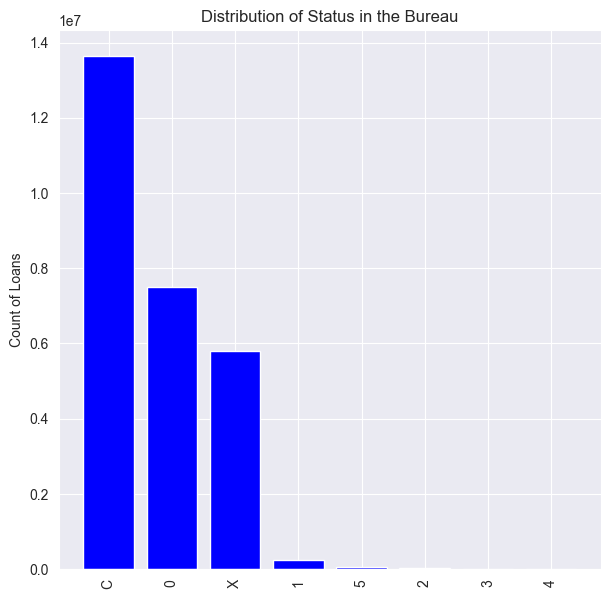

In [100]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
status_dict = dict(bureau_status_counter)
sorted_status_dict = dict(sorted(status_dict.items(), key=lambda kv: kv[1], reverse=True))


ind_3 = np.arange(len(sorted_status_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_3, list(sorted_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Status in the Bureau')
plt.xticks(ind_3, list(sorted_status_dict.keys()),rotation=90)
plt.show()

## 3.5 Feature Engineering on Bureau Data and Bureau Balance Data

In [101]:
def generate_credit_type_code(x):
    if x == 'Closed':
        y = 0
    elif x=='Active':
        y = 1
    else:
        y = 2
    return y


def FE_bureau_data_1(bureau_data):

    bureau_data['CREDIT_DURATION'] = -bureau_data['DAYS_CREDIT'] + bureau_data['DAYS_CREDIT_ENDDATE']
    bureau_data['ENDDATE_DIFF'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_ENDDATE_FACT']
    bureau_data['UPDATE_DIFF'] = bureau_data['DAYS_CREDIT_ENDDATE'] - bureau_data['DAYS_CREDIT_UPDATE']
    bureau_data['DEBT_PERCENTAGE'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_CREDIT_SUM_DEBT']
    bureau_data['DEBT_CREDIT_DIFF'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data['AMT_CREDIT_SUM_DEBT']
    bureau_data['CREDIT_TO_ANNUITY_RATIO'] = bureau_data['AMT_CREDIT_SUM'] / bureau_data['AMT_ANNUITY']
    bureau_data['DEBT_TO_ANNUITY_RATIO'] = bureau_data['AMT_CREDIT_SUM_DEBT'] / bureau_data['AMT_ANNUITY']
    bureau_data['CREDIT_OVERDUE_DIFF'] = bureau_data['AMT_CREDIT_SUM'] - bureau_data['AMT_CREDIT_SUM_OVERDUE']

    #Refer :- https://www.kaggle.com/c/home-credit-default-risk/discussion/57750
    #Calculating the Number of Past Loans for each Customer
    no_loans_per_customer = bureau_data[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby(by = \
                                                                    ['SK_ID_CURR'])['SK_ID_BUREAU'].count()
    no_loans_per_customer = no_loans_per_customer.reset_index().rename(columns={'SK_ID_BUREAU': 'CUSTOMER_LOAN_COUNT'})
    bureau_data = bureau_data.merge(no_loans_per_customer, on='SK_ID_CURR', how='left')

    #Calculating the Past Credit Types per Customer
    credit_types_per_customer = bureau_data[['SK_ID_CURR','CREDIT_TYPE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE'].nunique()
    credit_types_per_customer = credit_types_per_customer.reset_index().rename(columns={'CREDIT_TYPE':'CUSTOMER_CREDIT_TYPES'})
    bureau_data = bureau_data.merge(credit_types_per_customer, on='SK_ID_CURR',how='left')

    #Average Loan Type per Customer
    bureau_data['AVG_LOAN_TYPE'] = bureau_data['CUSTOMER_LOAN_COUNT']/bureau_data['CUSTOMER_CREDIT_TYPES']

    bureau_data['CREDIT_TYPE_CODE'] = bureau_data.apply(lambda x:\
                                        generate_credit_type_code(x.CREDIT_ACTIVE), axis=1)

    customer_credit_code_mean = bureau_data[['SK_ID_CURR','CREDIT_TYPE_CODE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE_CODE'].mean()
    customer_credit_code_mean.reset_index().rename(columns={'CREDIT_TYPE_CODE':'CUSTOMER_CREDIT_CODE_MEAN'})
    bureau_data = bureau_data.merge(customer_credit_code_mean, on='SK_ID_CURR', how='left')

    #Computing the Ratio of Total Customer Credit and the Total Customer Debt
    bureau_data['AMT_CREDIT_SUM'] = bureau_data['AMT_CREDIT_SUM'].fillna(0)
    bureau_data['AMT_CREDIT_SUM_DEBT'] = bureau_data['AMT_CREDIT_SUM_DEBT'].fillna(0)
    bureau_data['AMT_ANNUITY'] = bureau_data['AMT_ANNUITY'].fillna(0)

    credit_sum_customer = bureau_data[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=\
                                                                            ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum()
    credit_sum_customer = credit_sum_customer.reset_index().rename(columns={'AMT_CREDIT_SUM':'TOTAL_CREDIT_SUM'})
    bureau_data = bureau_data.merge(credit_sum_customer, on='SK_ID_CURR', how='left')

    credit_debt_sum_customer = bureau_data[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=\
                                                                        ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum()
    credit_debt_sum_customer = credit_debt_sum_customer.reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_DEBT_SUM'})
    bureau_data = bureau_data.merge(credit_debt_sum_customer, on='SK_ID_CURR', how='left')
    bureau_data['CREDIT_DEBT_RATIO'] = bureau_data['TOTAL_CREDIT_SUM']/bureau_data['TOTAL_DEBT_SUM']

    return bureau_data


In [102]:
bureau_data_fe = FE_bureau_data_1(bureau_data)

#One Hot Encoding the Bureau Datasets
bureau_data, bureau_data_columns = one_hot_encode(bureau_data_fe)
bureau_balance, bureau_balance_columns = one_hot_encode(bureau_balance)

In [103]:
def FE_bureau_data_2(bureau_data,bureau_balance,bureau_data_columns,bureau_balance_columns):

    bureau_balance_agg = {'MONTHS_BALANCE': ['min','max','mean','size']}

    for column in bureau_balance_columns:
        bureau_balance_agg[column] = ['min','max','mean','size']
        bureau_balance_final_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_agg)

    col_list_1 =[]

    for col in bureau_balance_final_agg.columns.tolist():
        col_list_1.append(col[0] + "_" + col[1].upper())

    bureau_balance_final_agg.columns = pd.Index(col_list_1)
    bureau_data_balance = bureau_data.join(bureau_balance_final_agg, how='left', on='SK_ID_BUREAU')
    bureau_data_balance.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

    del bureau_balance_final_agg
    gc.collect()


    numerical_agg = {'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],'AMT_CREDIT_SUM_OVERDUE': ['mean','sum'],
        'DAYS_CREDIT': ['mean', 'var'],'DAYS_CREDIT_UPDATE': ['mean','min'],'CREDIT_DAY_OVERDUE': ['mean','min'],
        'DAYS_CREDIT_ENDDATE': ['mean'],'CNT_CREDIT_PROLONG': ['sum'],'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],'AMT_CREDIT_MAX_OVERDUE': ['mean','max'],
        'AMT_ANNUITY': ['max', 'mean','sum'],'AMT_CREDIT_SUM': ['mean', 'sum','max']
      }
    categorical_agg = {}

    for col in bureau_data_columns:
        categorical_agg[col] = ['mean']
        categorical_agg[col] = ['max']

    for col in bureau_balance_columns:
        categorical_agg[col + "_MEAN"] = ['mean']
        categorical_agg[col + "_MIN"] = ['min']
        categorical_agg[col + "_MAX"] = ['max']

    bureau_data_balance_2 = bureau_data_balance.groupby('SK_ID_CURR').agg({**numerical_agg,\
                                                                       **categorical_agg})
    col_list_2=[]

    for col in bureau_data_balance_2.columns.tolist():
        col_list_2.append('BUREAU_'+col[0]+'_'+col[1])
    bureau_data_balance_2.columns = pd.Index(col_list_2)


    bureau_data_balance_3 = bureau_data_balance[bureau_data_balance['CREDIT_ACTIVE_Active'] == 1]
    bureau_data_balance_3_agg = bureau_data_balance_3.groupby('SK_ID_CURR').agg(numerical_agg)

    col_list_3=[]
    for col in bureau_data_balance_3_agg.columns.tolist():
        col_list_3.append('A_'+col[0]+'_'+col[1].upper())

    bureau_data_balance_3_agg.columns = pd.Index(col_list_3)
    b3_final = bureau_data_balance_2.join(bureau_data_balance_3_agg, how='left', \
                                      on='SK_ID_CURR')

    bureau_data_balance_4 = bureau_data_balance[bureau_data_balance['CREDIT_ACTIVE_Closed'] == 1]
    bureau_data_balance_4_agg = bureau_data_balance_4.groupby('SK_ID_CURR').agg(numerical_agg)
    col_list_4 =[]

    for col in bureau_data_balance_4_agg.columns.tolist():
        col_list_4.append('C_'+col[0]+'_'+col[1].upper())

    bureau_data_balance_4_agg.columns = pd.Index(col_list_4)
    bureau_data_balance_final = bureau_data_balance_2.join(bureau_data_balance_4_agg, \
                                                    how='left', on='SK_ID_CURR')

    del bureau_data_balance_3, bureau_data_balance_4_agg
    gc.collect()

    return bureau_data_balance_final

In [104]:
bureau_data_balance_final = FE_bureau_data_2(bureau_data, bureau_balance,bureau_data_columns,\
                                             bureau_balance_columns)
train_data_temp_2 = train_data_temp_1.join(bureau_data_balance_final, how='left', \
                                         on='SK_ID_CURR')

del bureau_data_balance_final
gc.collect()

train_data_temp_2.shape

(307511, 353)

# 4. Previous Application Dataset

## 4.1. Basic Overview of the Train Data

In [105]:
import pandas as pd

previous_application = reduce_memory_usage(pd.read_csv('../data/raw/previous_application.csv'))
print('Number of data points : ', previous_application.shape[0])
print('Number of features : ', previous_application.shape[1])
previous_application.head()


Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Number of data points :  1670214
Number of features :  37


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
previous_application.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

## 4.2 Previous Application Data Analysis

### 4.2.1 Univariate Analysis: Name_Cash_Loan_Purpose

In [107]:
application_loan_purpose = Counter()
for purpose in previous_application['NAME_CASH_LOAN_PURPOSE'].values:
    application_loan_purpose.update(purpose.split(','))

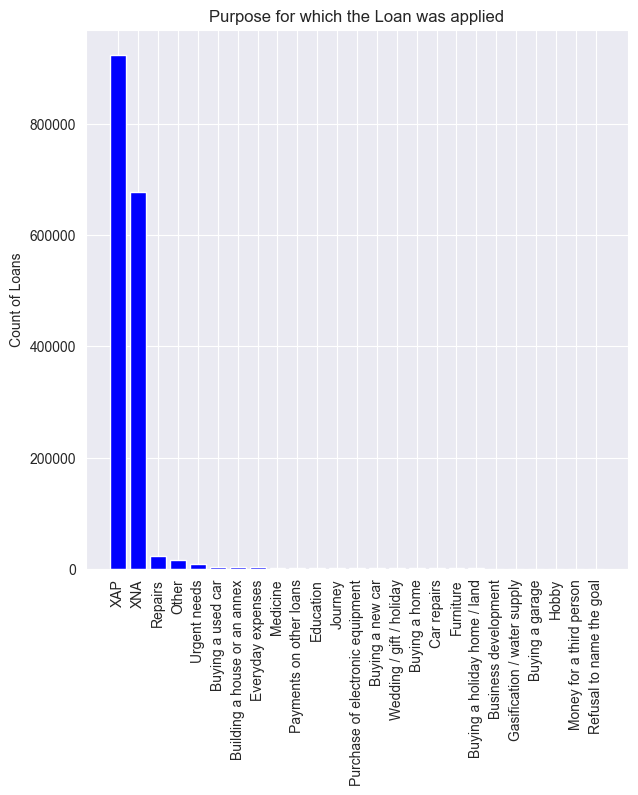

In [108]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
purpose_dict = dict(application_loan_purpose)
sorted_purpose_dict = dict(sorted(purpose_dict.items(), key=lambda kv: kv[1], reverse=True))

ind_4 = np.arange(len(sorted_purpose_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_4, list(sorted_purpose_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Purpose for which the Loan was applied')
plt.xticks(ind_4, list(sorted_purpose_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Mục đích của hầu hết các đơn xin vay là XAP, tiếp theo là XNA. Tuy nhiên, định nghĩa của những thuật ngữ này không được cung cấp trong file columns_description.csv.
* Điều này có thể có nghĩa là mục đích vay không được người vay chia sẻ, mặc dù chúng ta không thể chắc chắn.

### 4.2.2 Univariate Analysis: Name_Contract_Status

In [109]:
application_contract_status = Counter()
for status in previous_application['NAME_CONTRACT_STATUS'].values:
    application_contract_status.update(status.split(','))

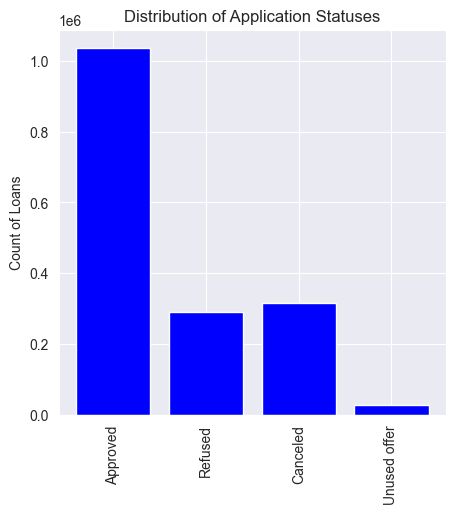

In [110]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
contract_status_dict = dict(application_contract_status)
sorted_contract_status_dict = dict(sorted(contract_status_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_5 = np.arange(len(contract_status_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_5, list(contract_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Application Statuses')
plt.xticks(ind_5, list(contract_status_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Hầu hết các đơn xin vay trước của khách hàng đều được phê duyệt.
* Tiếp theo là các đơn bị hủy và bị từ chối.
* Rất ít đơn được chấp thuận nhưng khoản vay lại không được người vay sử dụng.

### 4.2.3 Univariate Analysis: Name_Payment_Type

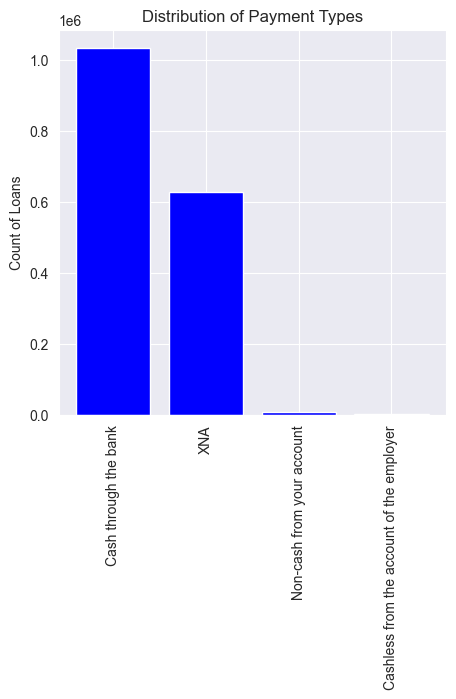

In [111]:
application_payment_type = Counter()
for type in previous_application['NAME_PAYMENT_TYPE'].values:
    application_payment_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
payment_type_dict = dict(application_payment_type)
sorted_payment_type_dict = dict(sorted(payment_type_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_6 = np.arange(len(payment_type_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_6, list(payment_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Payment Types')
plt.xticks(ind_6, list(payment_type_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Loại hình thanh toán về cơ bản đề cập đến phương thức mà khách hàng chọn để trả cho đơn vay trước đó, và như chúng ta thấy ở đây, hầu hết khách hàng đều chọn thanh toán bằng tiền mặt tại ngân hàng.
* Tiếp theo là những khách hàng có loại hình thanh toán là XNA.

### 4.2.4 Univariate Analysis: Code_Reject_Reason

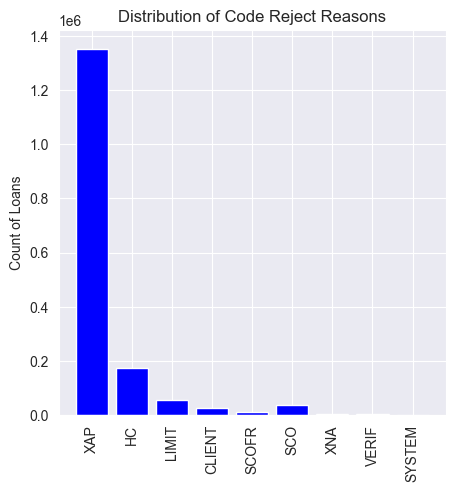

In [112]:
application_code_reject_reason = Counter()
for reason in previous_application['CODE_REJECT_REASON'].values:
    application_code_reject_reason.update(reason.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
code_reject_reason_dict = dict(application_code_reject_reason)
sorted_code_reject_reason_dict = dict(sorted(code_reject_reason_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_7 = np.arange(len(code_reject_reason_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_7, list(code_reject_reason_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Code Reject Reasons')
plt.xticks(ind_7, list(code_reject_reason_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Code_Reject_Reason về cơ bản đề cập đến lý do tại sao đơn vay trước của khách hàng bị ngân hàng từ chối. Như có thể thấy ở đây, trong hầu hết các trường hợp, lý do được cung cấp là XAP (Not Applicable). Tiếp theo là HC – lý do phổ biến thứ hai.

### 4.2.5 Univariate Analysis: Name_Client_Type

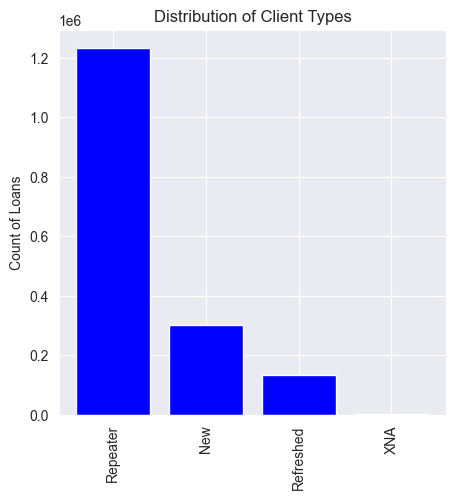

In [113]:
application_client_type = Counter()
for type in previous_application['NAME_CLIENT_TYPE'].values:
    application_client_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
client_type_dict = dict(application_client_type)
sorted_client_type_dict = dict(sorted(client_type_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_8 = np.arange(len(client_type_dict))
plt.figure(figsize=(5,5))
p1 = plt.bar(ind_8, list(client_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Client Types')
plt.xticks(ind_8, list(client_type_dict.keys()),rotation=90)
plt.show()

### 4.2.6 Univariate Analysis: Name_Goods_Category

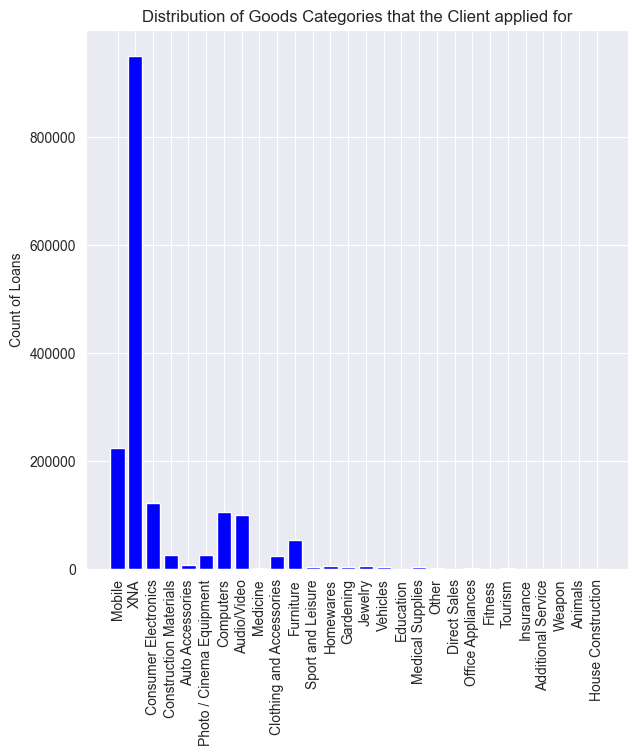

In [114]:
application_goods_category = Counter()
for category in previous_application['NAME_GOODS_CATEGORY'].values:
    application_goods_category.update(category.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
goods_category_dict = dict(application_goods_category)
sorted_goods_category = dict(sorted(goods_category_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_9 = np.arange(len(goods_category_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_9, list(goods_category_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Goods Categories that the Client applied for')
plt.xticks(ind_9, list(goods_category_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Cột này định nghĩa loại hàng hóa mà khách hàng đã đăng ký trong đơn vay trước, và như có thể thấy, XNA là nhóm hàng phổ biến nhất, tiếp theo là Mobiles.

### 4.2.7 Univariate Analysis: Name_Portfolio

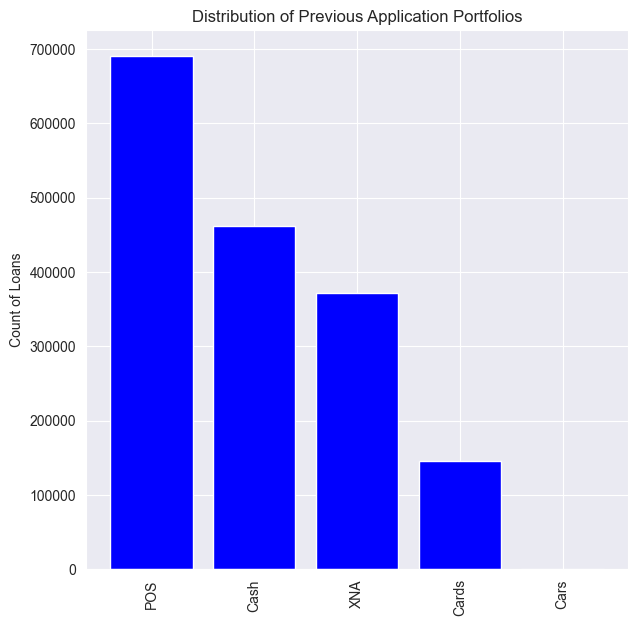

In [115]:
application_name_portfolio = Counter()
for name in previous_application['NAME_PORTFOLIO'].values:
    application_name_portfolio.update(name.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
application_name_dict = dict(application_name_portfolio)
sorted_name_portfolio = dict(sorted(application_name_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_10 = np.arange(len(application_name_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_10, list(application_name_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Previous Application Portfolios')
plt.xticks(ind_10, list(application_name_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Điều này cho thấy hầu hết các đơn xin vay trước đều là cho POS, tiếp theo là Cash và XNA.

### 4.2.8 Univariate Analysis: Channel_Type

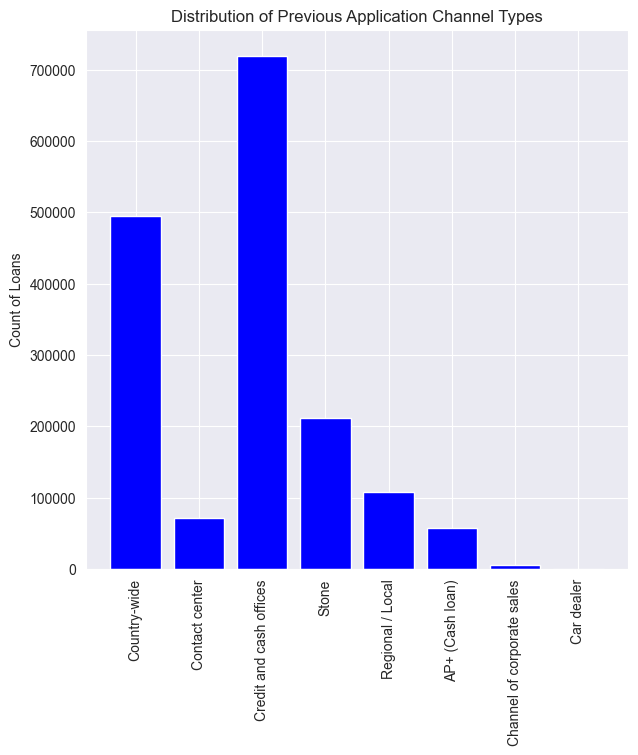

In [116]:
application_channel_type = Counter()
for type in previous_application['CHANNEL_TYPE'].values:
    application_channel_type.update(type.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
channel_type_dict = dict(application_channel_type)
sorted_channel_type = dict(sorted(application_channel_type.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_11 = np.arange(len(channel_type_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_11, list(channel_type_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Previous Application Channel Types')
plt.xticks(ind_11, list(channel_type_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Điều này cho thấy phần lớn khách hàng trong các đơn vay trước được ngân hàng tiếp cận qua các văn phòng Tín dụng và Tiền mặt, tiếp theo là kênh Toàn quốc

### 4.2.9 Univariate Analysis: Nflag_Insured_on_Approval

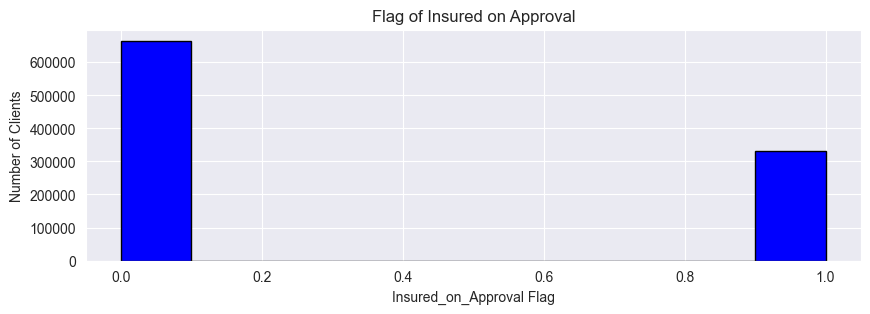

In [117]:
plt.figure(figsize=(10,3))
plt.hist(previous_application['NFLAG_INSURED_ON_APPROVAL'].values, bins=10, \
         edgecolor='black', color='blue')
plt.title('Flag of Insured on Approval')
plt.xlabel('Insured_on_Approval Flag')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Số khách hàng đăng ký bảo hiểm trong đơn vay trước rất ít so với số khách không đăng ký bảo hiểm.

## 4.3 Dealing with Null Values and Outliers

### 4.3.1 Days_Decision

In [118]:
previous_application['DAYS_DECISION'].describe()

count    1.670214e+06
mean    -8.806797e+02
std      7.790997e+02
min     -2.922000e+03
25%     -1.300000e+03
50%     -5.810000e+02
75%     -2.800000e+02
max     -1.000000e+00
Name: DAYS_DECISION, dtype: float64

In [119]:
print("The maximum Days_Decision (in years) across all applications = ",\
      - min(previous_application['DAYS_DECISION'].values)/365)

print("The minimum Days_Decision (in years) across all applications = ",\
      - max(previous_application['DAYS_DECISION'].values)/365)

The maximum Days_Decision (in years) across all applications =  8.005479452054795
The minimum Days_Decision (in years) across all applications =  0.0027397260273972603


**Kết luận rút ra:**
* Điều này về cơ bản có nghĩa rằng cả giá trị nhỏ nhất lẫn giá trị lớn nhất đều hợp lệ và không có ngoại lai nào xuất hiện trong cột Days_Decision

### 4.3.2 Days_First_Drawing

In [120]:
previous_application['DAYS_FIRST_DRAWING'].describe()

count    997149.000000
mean     342209.781250
std       88916.117188
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

In [121]:
print("The maximum Days_First_Drawing (in years) across all applications = ",\
       max(previous_application['DAYS_FIRST_DRAWING'].values)/365)

print("The minimum Days_First_Drawing (in years) across all applications = ",\
       min(previous_application['DAYS_FIRST_DRAWING'].values)/365)

The maximum Days_First_Drawing (in years) across all applications =  1000.6658
The minimum Days_First_Drawing (in years) across all applications =  -8.00548


In [122]:
previous_application['DAYS_FIRST_DRAWING'].replace(max(previous_application['DAYS_FIRST_DRAWING'].values),\
                                                  np.nan, inplace=True)

In [123]:
previous_application['DAYS_FIRST_DRAWING'].describe()

count    62705.000000
mean     -1035.246582
std        922.710327
min      -2922.000000
25%      -1721.000000
50%       -621.000000
75%       -303.000000
max         -2.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

### 4.3.3 Days_First_Due

In [124]:
previous_application['DAYS_FIRST_DUE'].describe()

count    997149.000000
mean      13826.266602
std       72444.867188
min       -2892.000000
25%       -1628.000000
50%        -831.000000
75%        -411.000000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64

In [125]:
previous_application['DAYS_FIRST_DUE'].replace(np.nan,0, inplace= True)

print("The minimum Days_First_Due (in years) across all applications = ",\
       min(previous_application['DAYS_FIRST_DUE'].values)/365)

print("The maximum Days_First_Due (in years) across all applications = ",\
       max(previous_application['DAYS_FIRST_DUE'].values)/365)

previous_application['DAYS_FIRST_DUE'].replace(0,np.nan, inplace= True)

The minimum Days_First_Due (in years) across all applications =  -7.923288
The maximum Days_First_Due (in years) across all applications =  1000.6658


In [126]:
previous_application['DAYS_FIRST_DUE'].replace(max(previous_application['DAYS_FIRST_DUE'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_FIRST_DUE'].describe()

count    956504.000000
mean      -1106.582886
std         790.703125
min       -2892.000000
25%       -1676.000000
50%        -874.000000
75%        -459.000000
max          -2.000000
Name: DAYS_FIRST_DUE, dtype: float64

### 4.3.4 Days_Last_Due_1st_Version

In [127]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].describe()

count    997149.000000
mean      33767.769531
std      106857.039062
min       -2801.000000
25%       -1242.000000
50%        -361.000000
75%         129.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

In [128]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(np.nan,0, inplace= True)

print("The minimum Days_Last_Due_1st_Version (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values)/365,3))

print("The maximum Days_Last_Due_1st_Version (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values)/365,3))

previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(0,np.nan, inplace= True)

The minimum Days_Last_Due_1st_Version (in years) across all applications =  -7.674
The maximum Days_Last_Due_1st_Version (in years) across all applications =  1000.666


In [129]:
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(max(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].describe()

count    902580.000000
mean       -677.687012
std         923.767822
min       -2801.000000
25%       -1360.000000
50%        -481.000000
75%          -2.000000
max        2389.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

### 4.3.5 Days_Last_Due

In [130]:
previous_application['DAYS_LAST_DUE'].describe()

count    997149.000000
mean      76582.406250
std      149647.421875
min       -2889.000000
25%       -1314.000000
50%        -537.000000
75%         -74.000000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64

In [131]:
previous_application['DAYS_LAST_DUE'].replace(np.nan,0, inplace= True)

print("The minimum Days_Last_Due (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_LAST_DUE'].values)/365,3))

print("The maximum Days_Last_Due (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_LAST_DUE'].values)/365,3))

previous_application['DAYS_LAST_DUE'].replace(0,np.nan, inplace= True)

The minimum Days_Last_Due (in years) across all applications =  -7.915
The maximum Days_Last_Due (in years) across all applications =  1000.666


In [132]:
previous_application['DAYS_LAST_DUE'].replace(max(previous_application['DAYS_LAST_DUE'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_LAST_DUE'].describe()

count    785928.000000
mean       -996.179199
std         752.703186
min       -2889.000000
25%       -1566.000000
50%        -801.000000
75%        -353.000000
max          -2.000000
Name: DAYS_LAST_DUE, dtype: float64

### 4.3.6 Days_Termination

In [133]:
previous_application['DAYS_TERMINATION'].describe()

count    997149.000000
mean      81992.343750
std      153303.515625
min       -2874.000000
25%       -1270.000000
50%        -499.000000
75%         -44.000000
max      365243.000000
Name: DAYS_TERMINATION, dtype: float64

In [134]:
previous_application['DAYS_TERMINATION'].replace(np.nan,0, inplace= True)

print("The minimum Days_Termination (in years) across all applications = ",\
       np.round(min(previous_application['DAYS_TERMINATION'].values)/365,3))

print("The maximum Days_Termination (in years) across all applications = ",\
       np.round(max(previous_application['DAYS_TERMINATION'].values)/365,3))

previous_application['DAYS_TERMINATION'].replace(0,np.nan, inplace= True)

The minimum Days_Termination (in years) across all applications =  -7.874
The maximum Days_Termination (in years) across all applications =  1000.666


In [135]:
previous_application['DAYS_TERMINATION'].replace(max(previous_application['DAYS_TERMINATION'].values),\
                                                  np.nan, inplace=True)
previous_application['DAYS_TERMINATION'].describe()

count    771236.000000
mean       -978.375244
std         749.134277
min       -2874.000000
25%       -1539.000000
50%        -780.000000
75%        -337.000000
max          -2.000000
Name: DAYS_TERMINATION, dtype: float64

## 4.4 Feature Engineering on Previous Application

In [136]:
def FE_previous_application(previous_application):

    prev_app, previous_application_columns = one_hot_encode(previous_application)

    prev_app['APPLICATION_CREDIT_DIFF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_CREDIT']
    prev_app['APPLICATION_CREDIT_RATIO'] = prev_app['AMT_APPLICATION'] / prev_app['AMT_CREDIT']
    prev_app['CREDIT_TO_ANNUITY_RATIO'] = prev_app['AMT_CREDIT']/prev_app['AMT_ANNUITY']
    prev_app['DOWN_PAYMENT_TO_CREDIT'] = prev_app['AMT_DOWN_PAYMENT'] / prev_app['AMT_CREDIT']

    total_payment = prev_app['AMT_ANNUITY'] * prev_app['CNT_PAYMENT']
    prev_app['SIMPLE_INTERESTS'] = (total_payment/prev_app['AMT_CREDIT'] - 1)/prev_app['CNT_PAYMENT']

    prev_app['DAYS_LAST_DUE_DIFF'] = prev_app['DAYS_LAST_DUE_1ST_VERSION'] - prev_app['DAYS_LAST_DUE']

    numerical_agg_prev = {'AMT_ANNUITY': ['max', 'mean'], 'AMT_APPLICATION': ['max','mean'],\
                     'AMT_CREDIT':['max','mean'], 'AMT_DOWN_PAYMENT': ['max','mean'],\
                      'AMT_GOODS_PRICE':['mean','sum'], 'HOUR_APPR_PROCESS_START' :\
                      ['max','mean'], 'RATE_DOWN_PAYMENT':['max','mean'], 'RATE_INTEREST_PRIMARY':\
                      ['max','mean'],'RATE_INTEREST_PRIVILEGED':['max','mean'], \
                      'DAYS_DECISION': ['max','mean'], 'CNT_PAYMENT' :['mean','sum'], \
                      'DAYS_FIRST_DRAWING': ['max','mean'], 'DAYS_TERMINATION' : ['max','mean'],\
                      'APPLICATION_CREDIT_RATIO': ['max','mean'], 'DOWN_PAYMENT_TO_CREDIT' : \
                      ['max','mean'], 'DAYS_LAST_DUE_DIFF': ['max','mean']}

    categorical_agg_prev = {}

    for column in previous_application_columns:
        categorical_agg_prev[column] = ['mean']

    prev_app_agg1 = prev_app.groupby('SK_ID_CURR').agg({**numerical_agg_prev, \
                                                    **categorical_agg_prev})
    col_list_5 =[]

    for col in prev_app_agg1.columns.tolist():
        col_list_5.append('PREV_'+col[0]+'_'+col[1].upper())

    prev_app_agg1.columns = pd.Index(col_list_5)

    prev_app_cs_approved = prev_app[prev_app['NAME_CONTRACT_STATUS_Approved']==1]
    prev_app_agg2 = prev_app_cs_approved.groupby('SK_ID_CURR').agg(numerical_agg_prev)

    col_list_6 = []

    for col in prev_app_agg2.columns.tolist():
        col_list_6.append('CS_APP_' + col[0] + '_' + col[1].upper())

    prev_app_agg2.columns = pd.Index(col_list_6)

    prev_app_agg1_join = prev_app_agg1.join(prev_app_agg2, how='left', on='SK_ID_CURR')

    prev_app_cs_refused = prev_app[prev_app['NAME_CONTRACT_STATUS_Refused']==1]
    prev_app_agg3 = prev_app_cs_refused.groupby('SK_ID_CURR').agg(numerical_agg_prev)

    col_list_7 =[]

    for col in prev_app_agg3.columns.tolist():
        col_list_7.append('CS_REF_' + col[0] + '_' + col[1].upper())

    prev_app_agg3.columns = pd.Index(col_list_7)
    prev_app_agg_final = prev_app_agg1_join.join(prev_app_agg3,how='left', on='SK_ID_CURR')

    del prev_app_agg1_join, prev_app_agg3, prev_app_cs_refused, prev_app_agg1, prev_app_agg2,\
        prev_app_cs_approved
    gc.collect()
    return prev_app_agg_final

In [137]:
def FE_previous_application_days_decision(data,data_temp,previous_application):

    temp_1 = FE_previous_application(reduce_memory_usage(previous_application))
    data = data_temp.merge(temp_1, how='left', on='SK_ID_CURR')
    del temp_1
    gc.collect()

    temp_2 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-365].reset_index())
    temp_2.drop(['index'], axis=1, inplace=True)
    temp_2 = FE_previous_application(temp_2)
    data = data.join(temp_2, how='left', on='SK_ID_CURR',rsuffix='_year')
    del temp_2
    gc.collect()

    temp_3 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-182].reset_index())
    temp_3.drop(['index'], axis=1, inplace=True)
    temp_3 = FE_previous_application(temp_3)
    data = data.join(temp_3, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_3
    gc.collect()

    temp_4 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-90].reset_index())
    temp_4.drop(['index'], axis=1, inplace=True)
    temp_4 = FE_previous_application(temp_4)
    data = data.join(temp_4, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_4
    gc.collect()

    temp_5 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-30].reset_index())
    temp_5.drop(['index'], axis=1, inplace=True)
    temp_5 = FE_previous_application(temp_5)
    data = data.join(temp_5, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_5
    gc.collect()

    temp_6 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-14].reset_index())
    temp_6.drop(['index'], axis=1, inplace=True)
    temp_6 = FE_previous_application(temp_6)
    data = data.join(temp_6, how='left', on='SK_ID_CURR', rsuffix='_fortnight')
    del temp_6
    gc.collect()

    temp_7 = reduce_memory_usage(previous_application[previous_application['DAYS_DECISION']>=-7].reset_index())
    temp_7.drop(['index'], axis=1, inplace=True)
    temp_7 = FE_previous_application(temp_7)
    data = data.join(temp_7, how='left', on='SK_ID_CURR', rsuffix='_week')
    del temp_7
    gc.collect()

    return data

In [138]:
train_data_temp_2 = FE_previous_application_days_decision(train_data, train_data_temp_2,previous_application)
train_data_temp_2.shape

Memory usage of dataframe is 309.01 MB
Memory usage after optimization is: 293.08 MB
Decreased by 5.2%
Memory usage of dataframe is 105.06 MB
Memory usage after optimization is: 102.87 MB
Decreased by 2.1%
Memory usage of dataframe is 40.52 MB
Memory usage after optimization is: 39.67 MB
Decreased by 2.1%
Memory usage of dataframe is 16.19 MB
Memory usage after optimization is: 15.77 MB
Decreased by 2.6%
Memory usage of dataframe is 6.82 MB
Memory usage after optimization is: 6.65 MB
Decreased by 2.6%
Memory usage of dataframe is 3.22 MB
Memory usage after optimization is: 3.13 MB
Decreased by 2.6%
Memory usage of dataframe is 1.57 MB
Memory usage after optimization is: 1.53 MB
Decreased by 2.6%


(307511, 2084)

# 5. POS Cash Balance Dataset

## 5.1. Basic Overview of the POS Cash Balance Data

In [139]:
import pandas as pd

# Đọc trực tiếp file CSV local (không qua MinIO)
pos_cash_balance = pd.read_csv(
    '../data/raw/POS_CASH_balance.csv'
)

print('Number of data points : ', pos_cash_balance.shape[0])
print('Number of features    : ', pos_cash_balance.shape[1])

# Nếu bạn có hàm reduce_memory_usage:
pos_cash_balance = reduce_memory_usage(pos_cash_balance)

pos_cash_balance.head()


Number of data points :  10001358
Number of features    :  8
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [140]:
pos_cash_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

## 5.2 POS Cash Balance Data Analysis

### 5.2.1 Univariate Analysis : Months_Balance

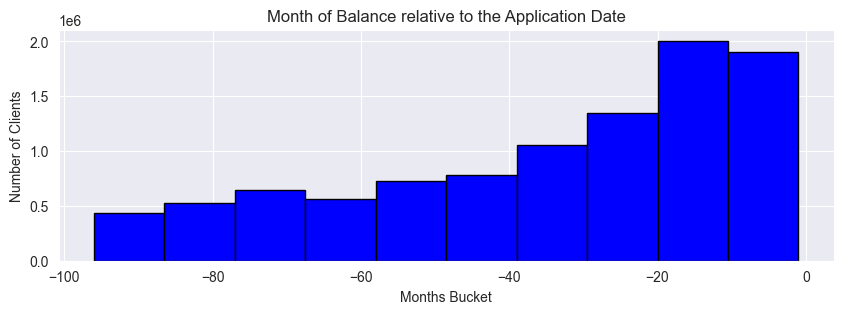

In [141]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['MONTHS_BALANCE'].values, bins=10, edgecolor='black', color='blue')
plt.title('Month of Balance relative to the Application Date')
plt.xlabel('Months Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Đa số khách hàng có Months_Balance nằm trong khoảng 10–20 tháng trước ngày nộp hồ sơ.
* Tiếp theo là nhóm khách có Months_Balance dưới 10 tháng.

### 5.2.2 Univariate Analysis : Cnt_Instalment

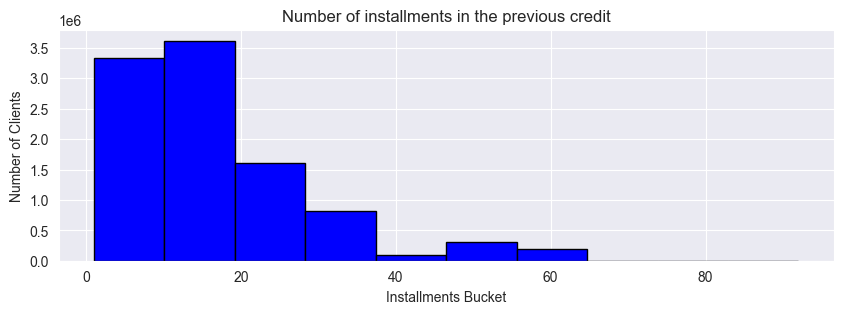

In [142]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['CNT_INSTALMENT'].values, bins=10, edgecolor='black', color='blue')
plt.title('Number of installments in the previous credit')
plt.xlabel('Installments Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Số kỳ trả trong khoản vay trước của hầu hết khách hàng nằm trong khoảng từ 10 đến 20 kỳ.
* Tiếp theo là nhóm khách có số kỳ trả dưới 10 kỳ.

### 5.2.3 Univariate Analysis : Cnt_Instalment_Future

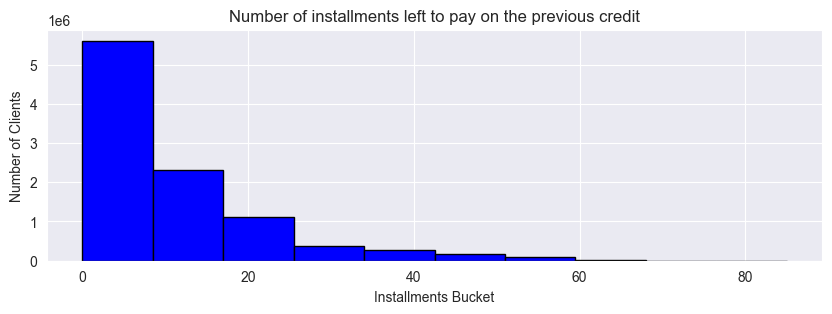

In [143]:
plt.figure(figsize=(10,3))
plt.hist(pos_cash_balance['CNT_INSTALMENT_FUTURE'].values, bins=10, edgecolor='black', color='blue')
plt.title('Number of installments left to pay on the previous credit')
plt.xlabel('Installments Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Hầu hết khách hàng còn dưới 10 kỳ thanh toán cho khoản vay trước.
* Tiếp theo là nhóm khách có số kỳ còn lại từ 10 đến 20.

### 5.2.4 Univariate Analysis : Name_Contract_Status

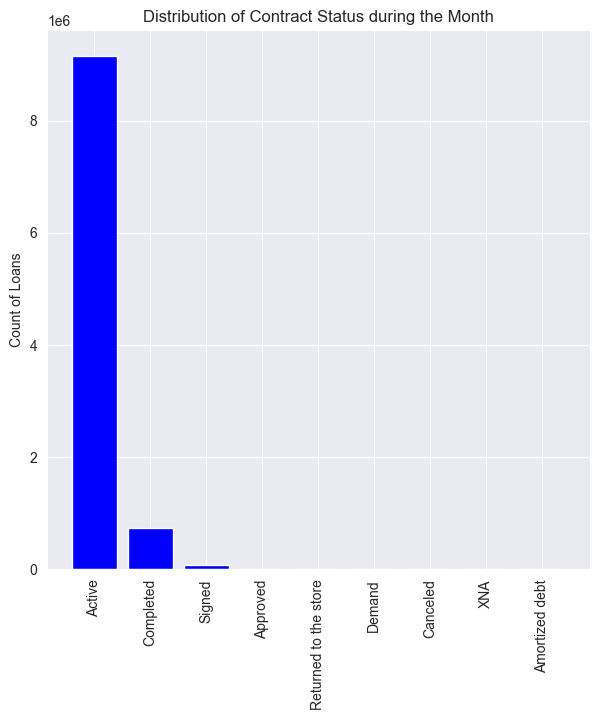

In [144]:
balance_contract_status = Counter()
for status in pos_cash_balance['NAME_CONTRACT_STATUS'].values:
    balance_contract_status.update(status.split(','))

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
contract_status_dict = dict(balance_contract_status)
sorted_contract_status = dict(sorted(balance_contract_status.items(), \
                                        key=lambda kv: kv[1], reverse=True))

ind_12 = np.arange(len(contract_status_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_12, list(contract_status_dict.values()),color='blue')

plt.ylabel('Count of Loans')
plt.title('Distribution of Contract Status during the Month')
plt.xticks(ind_12, list(contract_status_dict.keys()),rotation=90)
plt.show()

**Kết luận rút ra:**
* Trong đa số trường hợp, giá trị của Name_Contract_Status là Active

## 5.3 Feature Engineering on POS Cash Balance Dataset

#### Function to carry out Feature Engineering for Multiple features

In [145]:
def FE_pos_cash_balance(pos_cash_balance):

    pos_balance_data, pos_balance_columns = one_hot_encode(pos_cash_balance)

    pos_balance_data['LATE_PAYMENT'] = pos_balance_data['SK_DPD'].apply(lambda x:1 \
                                                if x>0 else 0)
    numerical_agg_pos_balance = {'SK_DPD_DEF': ['max', 'mean','min'],'SK_DPD': ['max', 'mean','min'],
        'MONTHS_BALANCE': ['max', 'mean', 'size'], 'CNT_INSTALMENT': ['max','size'],
        'CNT_INSTALMENT_FUTURE': ['max','size','sum']}

    categorical_agg_pos_balance = {}

    for col in pos_balance_columns:
        categorical_agg_pos_balance[col] = ['mean']

    pos_balance_agg = pos_balance_data.groupby('SK_ID_CURR').agg({**numerical_agg_pos_balance, \
                                                    **categorical_agg_pos_balance})
    col_list_8=[]
    for col in pos_balance_agg.columns.tolist():
        col_list_8.append('POS_'+col[0] + '_' + col[1].upper())

    pos_balance_agg.columns = pd.Index(col_list_8)

    sort_pos_balance = pos_balance_data.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    pos_group = sort_pos_balance.groupby('SK_ID_PREV')

    pos_final_df = pd.DataFrame()
    pos_final_df['SK_ID_CURR'] = pos_group['SK_ID_CURR'].first()
    pos_final_df['MONTHS_BALANCE_MAX'] = pos_group['MONTHS_BALANCE'].max()

    pos_final_df['POS_LOAN_COMPLETED_MEAN'] = pos_group['NAME_CONTRACT_STATUS_Completed'].mean()
    pos_final_df['POS_COMPLETED_BEFORE_MEAN'] = pos_group['CNT_INSTALMENT'].first() - \
                                            pos_group['CNT_INSTALMENT'].last()
    pos_final_df['POS_COMPLETED_BEFORE_MEAN'] = pos_final_df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)

    pos_final_df['POS_REMAINING_INSTALMENTS'] = pos_group['CNT_INSTALMENT_FUTURE'].last()
    pos_final_df['POS_REMAINING_INSTALMENTS_RATIO'] = pos_group['CNT_INSTALMENT_FUTURE'].last()/pos_group['CNT_INSTALMENT'].last()

    pos_final_df_groupby = pos_final_df.groupby('SK_ID_CURR').sum().reset_index()
    pos_final_df_groupby.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_final_agg = pd.merge(pos_balance_agg, pos_final_df_groupby, on= 'SK_ID_CURR',\
                         how= 'left')

    del pos_balance_agg, pos_final_df_groupby, pos_group, sort_pos_balance
    gc.collect()
    return pos_final_agg

#### Function to carry out Feature Engineering using 'Months_Balance'

In [146]:
def FE_pos_cash_balance_months_balance(data, data_temp, pos_cash_balance):

    temp_8 = FE_pos_cash_balance(reduce_memory_usage(pos_cash_balance))
    data = data_temp.merge(temp_8, how='left', on='SK_ID_CURR')
    del temp_8
    gc.collect()

    temp_9 = reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-12].reset_index())
    temp_9.drop(['index'], axis=1, inplace=True)
    temp_9 = FE_pos_cash_balance(temp_9)
    data = data.join(temp_9, how='left', on='SK_ID_CURR',rsuffix='_year')
    del temp_9
    gc.collect()

    temp_10 = reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-6].reset_index())
    temp_10.drop(['index'], axis=1, inplace=True)
    temp_10 = FE_pos_cash_balance(temp_10)
    data = data.join(temp_10, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_10
    gc.collect()

    temp_11 = reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-3].reset_index())
    temp_11.drop(['index'], axis=1, inplace=True)
    temp_11 = FE_pos_cash_balance(temp_11)
    data = data.join(temp_11, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_11
    gc.collect()

    temp_12 = reduce_memory_usage(pos_cash_balance[pos_cash_balance['MONTHS_BALANCE']>=-1].reset_index())
    temp_12.drop(['index'], axis=1, inplace=True)
    temp_12 = FE_pos_cash_balance(temp_12)
    data = data.join(temp_12, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_12
    gc.collect()

    return data

#### Carrying out Feature Engineering using the Functions Defined

In [147]:
train_data_temp_2 = FE_pos_cash_balance_months_balance(train_data,train_data_temp_2, pos_cash_balance)
train_data_temp_2.shape

Memory usage of dataframe is 238.45 MB
Memory usage after optimization is: 238.45 MB
Decreased by 0.0%
Memory usage of dataframe is 73.51 MB
Memory usage after optimization is: 64.60 MB
Decreased by 12.1%
Memory usage of dataframe is 33.01 MB
Memory usage after optimization is: 29.00 MB
Decreased by 12.1%
Memory usage of dataframe is 14.10 MB
Memory usage after optimization is: 12.39 MB
Decreased by 12.1%


KeyboardInterrupt: 

# 6. Installments Payments Dataset

## 6.1. Basic Overview of the Installments Payments Data

In [156]:
import pandas as pd

# Đọc trực tiếp file CSV local (không qua MinIO)
installments_payments = pd.read_csv(
    '../data/raw/installments_payments.csv'
)

print('Number of data points : ', installments_payments.shape[0])
print('Number of features    : ', installments_payments.shape[1])

# Giảm dung lượng bộ nhớ nếu cần
installments_payments = reduce_memory_usage(installments_payments)

installments_payments.head()


Number of data points :  13605401
Number of features    :  8
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [157]:
installments_payments.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

## 6.2 Installments Payments Data Analysis

### 6.2.1 Univariate Analysis : Num_Instalment_Number

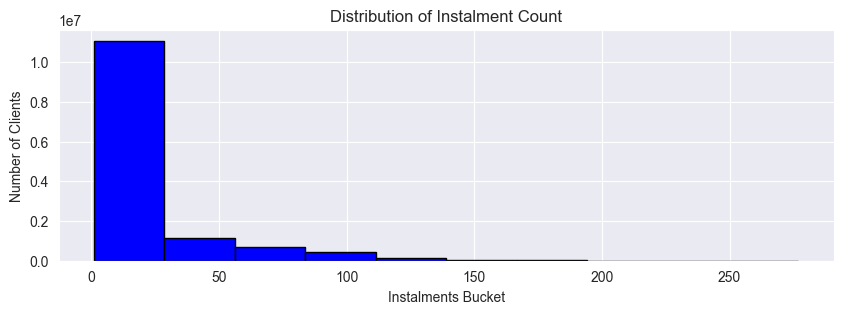

In [158]:
plt.figure(figsize=(10,3))
plt.hist(installments_payments['NUM_INSTALMENT_NUMBER'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Instalment Count')
plt.xlabel('Instalments Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Hầu hết khách hàng đều hoàn tất thanh toán đợt đầu trước 25 tháng.

### 6.2.2 Univariate Analysis : Amt_Payment

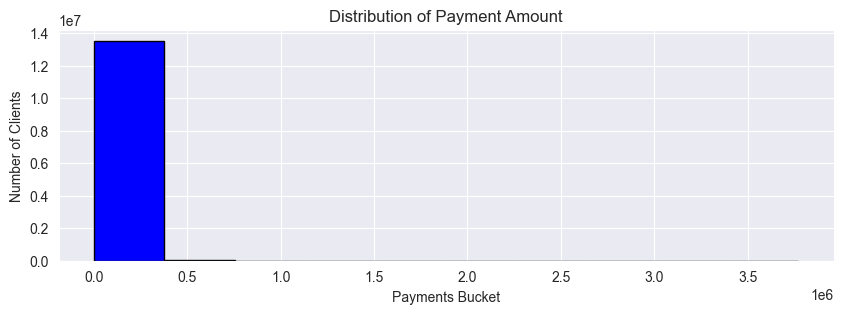

In [159]:
plt.figure(figsize=(10,3))
plt.hist(installments_payments['AMT_PAYMENT'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Payment Amount')
plt.xlabel('Payments Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Hầu hết khách hàng đã trả ít hơn 5 lakh cho khoản tín dụng trước đó trong cùng một đợt trả góp.

## 6.3 Feature Engineering on Installments Payments Data

Function to carry out Feature Engineering for Multiple features

In [160]:
def FE_installments_payments(installments_payments):

    pay1 = installments_payments[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']+ ['AMT_PAYMENT']]
    pay2 = pay1.groupby(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()
    pay_final = pay2.rename(columns={'AMT_PAYMENT': 'AMT_PAYMENT_GROUPED'})
    payments_final = installments_payments.merge(pay_final,\
                            on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], how='left')

    payments_final['PAYMENT_DIFFERENCE'] = payments_final['AMT_INSTALMENT'] - \
                                       payments_final['AMT_PAYMENT_GROUPED']
    payments_final['PAYMENT_RATIO'] = payments_final['AMT_INSTALMENT'] / payments_final['AMT_PAYMENT_GROUPED']

    payments_final['PAID_OVER_AMOUNT'] = payments_final['AMT_PAYMENT'] - \
                                     payments_final['AMT_INSTALMENT']
    payments_final['PAID_OVER'] = (payments_final['PAID_OVER_AMOUNT'] > 0).astype(int)

    payments_final['DPD'] = payments_final['DAYS_ENTRY_PAYMENT'] - \
                        payments_final['DAYS_INSTALMENT']
    payments_final['DPD'] = payments_final['DPD'].apply(lambda x: 0 if x <= 0 else x)

    payments_final['DBD'] = payments_final['DAYS_INSTALMENT'] - \
                        payments_final['DAYS_ENTRY_PAYMENT']
    payments_final['DBD'] = payments_final['DBD'].apply(lambda x: 0 if x <= 0 else x)
    payments_final['LATE_PAYMENT'] = payments_final['DBD'].apply(lambda x: 1 if x > 0 else 0)

    payments_final['INSTALMENT_PAYMENT_RATIO'] = payments_final['AMT_PAYMENT'] / payments_final['AMT_INSTALMENT']
    payments_final['LATE_PAYMENT_RATIO'] = payments_final.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

    payments_final['SIGNIFICANT_LATE_PAYMENT'] = payments_final['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)

    payments_final['DPD_7'] = payments_final['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    payments_final['DPD_15'] = payments_final['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    payments_final['DPD_30'] = payments_final['DPD'].apply(lambda x: 1 if x >= 30 else 0)
    payments_final['DPD_60'] = payments_final['DPD'].apply(lambda x: 1 if x >= 60 else 0)
    payments_final['DPD_90'] = payments_final['DPD'].apply(lambda x: 1 if x >= 90 else 0)
    payments_final['DPD_180'] = payments_final['DPD'].apply(lambda x: 1 if x >= 180 else 0)
    payments_final['DPD_WOF'] = payments_final['DPD'].apply(lambda x: 1 if x >= 720 else 0)

    payments_final, pay_final_columns = one_hot_encode(payments_final)

    numeric_agg_payments = {'LATE_PAYMENT': ['max','mean','min'],'AMT_PAYMENT': ['min', 'max',\
                      'mean', 'sum'], 'NUM_INSTALMENT_VERSION': ['nunique'], \
                      'NUM_INSTALMENT_NUMBER':['max'], 'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'PAYMENT_DIFFERENCE': ['max','mean','min','sum'],'DAYS_ENTRY_PAYMENT': ['max', \
        'mean', 'sum'],  'PAID_OVER_AMOUNT': ['max','mean','min']
               }

    for col in pay_final_columns:
        numeric_agg_payments[col] = ['mean']

    payments_final_agg = payments_final.groupby('SK_ID_CURR').agg(numeric_agg_payments)
    col_list_9=[]

    for col in payments_final_agg.columns.tolist():
        col_list_9.append('INS_'+col[0]+'_'+col[1].upper())

    payments_final_agg.columns = pd.Index(col_list_9)
    payments_final_agg['INSTALLATION_COUNT'] = payments_final.groupby('SK_ID_CURR').size()

    del payments_final
    gc.collect()

    return payments_final_agg

Function to carry out Feature Engineering using 'Days_Instalment'

In [161]:
def FE_installments_payments_days_instalment(data, data_temp, installments_payments):

    installments_payments['DAYS_ENTRY_PAYMENT'].fillna(0, inplace=True)
    installments_payments['AMT_PAYMENT'].fillna(0.0, inplace=True)

    temp_13 = FE_installments_payments(reduce_memory_usage(installments_payments))
    data = data_temp.join(temp_13, how='left', on='SK_ID_CURR')
    del temp_13
    gc.collect()

    temp_14 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-365].reset_index())
    temp_14.drop(['index'], axis=1, inplace=True)
    temp_14 = FE_installments_payments(temp_14)
    data = data.join(temp_14, how='left', on='SK_ID_CURR', rsuffix='_year')
    del temp_14
    gc.collect()

    temp_15 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-182].reset_index())
    temp_15.drop(['index'], axis=1, inplace=True)
    temp_15 = FE_installments_payments(temp_15)
    data = data.join(temp_15, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_15
    gc.collect()

    temp_16 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-90].reset_index())
    temp_16.drop(['index'], axis=1, inplace=True)
    temp_16 = FE_installments_payments(temp_16)
    data = data.join(temp_16, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_16
    gc.collect()

    temp_17 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-30].reset_index())
    temp_17.drop(['index'], axis=1, inplace=True)
    temp_17 = FE_installments_payments(temp_17)
    data = data.join(temp_17, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_17
    gc.collect()

    temp_18 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-14].reset_index())
    temp_18.drop(['index'], axis=1, inplace=True)
    temp_18 = FE_installments_payments(temp_18)
    data = data.join(temp_18, how='left', on='SK_ID_CURR', rsuffix='_fortnight')
    del temp_18
    gc.collect()

    temp_19 = reduce_memory_usage(installments_payments[installments_payments['DAYS_INSTALMENT']>=-7].reset_index())
    temp_19.drop(['index'], axis=1, inplace=True)
    temp_19 = FE_installments_payments(temp_19)
    data = data.join(temp_19, how='left', on='SK_ID_CURR', rsuffix='_week')
    del temp_19
    gc.collect()

    return data

In [162]:
train_data_temp_2 = FE_installments_payments_days_instalment(train_data,train_data_temp_2,installments_payments)
train_data_temp_2.shape

Memory usage of dataframe is 311.40 MB
Memory usage after optimization is: 311.40 MB
Decreased by 0.0%
Memory usage of dataframe is 105.17 MB
Memory usage after optimization is: 92.03 MB
Decreased by 12.5%
Memory usage of dataframe is 51.33 MB
Memory usage after optimization is: 44.91 MB
Decreased by 12.5%
Memory usage of dataframe is 23.63 MB
Memory usage after optimization is: 20.67 MB
Decreased by 12.5%
Memory usage of dataframe is 6.77 MB
Memory usage after optimization is: 5.92 MB
Decreased by 12.5%
Memory usage of dataframe is 2.49 MB
Memory usage after optimization is: 2.17 MB
Decreased by 12.5%
Memory usage of dataframe is 0.96 MB
Memory usage after optimization is: 0.84 MB
Decreased by 12.5%


(307511, 2388)

# 7. Credit Card Balance Dataset

## 7.1. Basic Overview of the 'Credit Card Balance' Dataset

In [163]:
import pandas as pd

# Đọc trực tiếp file CSV local (không qua MinIO)
credit_card_balance = pd.read_csv(
    '../data/raw/credit_card_balance.csv'
)

print('Number of data points : ', credit_card_balance.shape[0])
print('Number of features    : ', credit_card_balance.shape[1])

# Giảm dung lượng bộ nhớ nếu cần
credit_card_balance = reduce_memory_usage(credit_card_balance)

credit_card_balance.head()


Number of data points :  3840312
Number of features    :  23
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [164]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

## 7.2 Credit Card Balance EDA

### 7.2.1 Univariate Analysis : Months_Balance

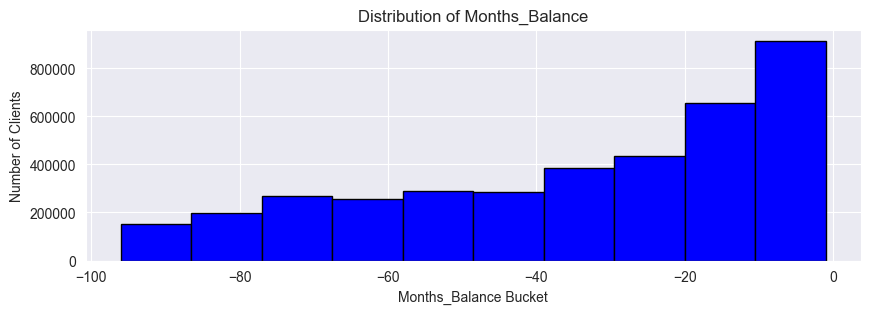

In [165]:
plt.figure(figsize=(10,3))
plt.hist(credit_card_balance['MONTHS_BALANCE'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Months_Balance')
plt.xlabel('Months_Balance Bucket')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Hầu hết khách hàng có Months_Balance từ 0-10 tháng trước ngày nộp đơn.

### 7.2.2 Univariate Analysis : Cnt_Drawings_Current

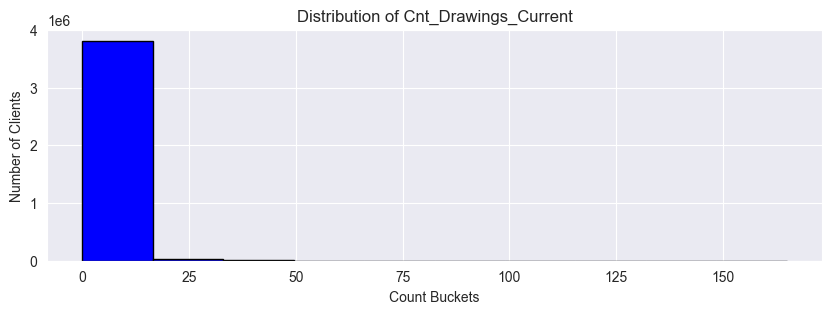

In [166]:
plt.figure(figsize=(10,3))
plt.hist(credit_card_balance['CNT_DRAWINGS_CURRENT'].values, bins=10, edgecolor='black',\
         color='blue')
plt.title('Distribution of Cnt_Drawings_Current')
plt.xlabel('Count Buckets')
plt.ylabel('Number of Clients')
plt.show()

**Kết luận rút ra:**
* Đa số khách hàng có số tháng rút tiền trong tháng hiện tại của khoản vay trước đây dưới 25 tháng, chỉ có một số rất ít ngoại lệ.

### 7.2.3 Univariate Analysis : Cnt_Instalment_Mature_Cum

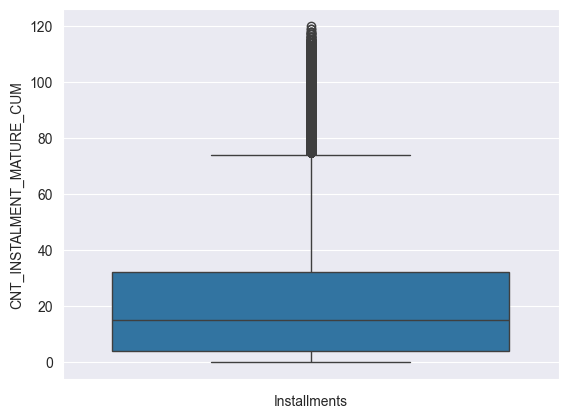

In [167]:
sns.boxplot(y='CNT_INSTALMENT_MATURE_CUM', data=credit_card_balance)
plt.xlabel('Installments')
plt.show()

In [171]:
credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].describe()

count    3535076.0
mean           NaN
std            0.0
min            0.0
25%            4.0
50%           15.0
75%           32.0
max          120.0
Name: CNT_INSTALMENT_MATURE_CUM, dtype: float64

**Kết luận rút ra:**
* Giá trị nhỏ nhất của Cnt_Instalment_Mature_Cum là 0, giá trị lớn nhất là 120.
* 75% tổng số quan sát có giá trị dưới 32

## 7.3 Feature Engineering on Credit Card Balance Data

Function to carry out Feature Engineering for Multiple features

In [172]:
def FE_credit_card_balance(credit_card_balance):

    cc_balance_data, cc_balance_columns = one_hot_encode(credit_card_balance)
    cc_balance_data.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)

    cc_balance_data['LIMIT_USE'] = cc_balance_data['AMT_BALANCE'] / cc_balance_data['AMT_CREDIT_LIMIT_ACTUAL']
    cc_balance_data['PAYMENT_DIV_MIN'] = cc_balance_data['AMT_PAYMENT_CURRENT'] / cc_balance_data['AMT_INST_MIN_REGULARITY']
    cc_balance_data['LATE_PAYMENT'] = cc_balance_data['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

    cc_balance_data['DRAWING_LIMIT_RATIO'] = cc_balance_data['AMT_DRAWINGS_ATM_CURRENT'] / cc_balance_data['AMT_CREDIT_LIMIT_ACTUAL']

    cc_balance_data.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_balance_data_agg = cc_balance_data.groupby('SK_ID_CURR').agg(['max', 'mean', 'sum', 'var'])

    col_list_9=[]

    for col in cc_balance_data_agg.columns.tolist():
        col_list_9.append('CR_'+col[0]+'_'+col[1].upper())

    cc_balance_data_agg.columns = pd.Index(col_list_9)

    cc_balance_data_agg['CREDIT_COUNT'] = cc_balance_data.groupby('SK_ID_CURR').size()

    del cc_balance_data, cc_balance_columns
    gc.collect()

    return cc_balance_data_agg

Function to carry out Feature Engineering using 'Months_Balance'

In [173]:
def FE_credit_card_balance_months_balance(data,data_temp,credit_card_balance):

    temp_20 = FE_credit_card_balance(reduce_memory_usage(credit_card_balance))
    data = data_temp.join(temp_20, how='left', on='SK_ID_CURR')
    del temp_20
    gc.collect()

    temp_21 = reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-12].reset_index())
    temp_21.drop(['index'], axis=1, inplace=True)
    temp_21 = FE_credit_card_balance(temp_21)
    data = data.join(temp_21, how='left', on='SK_ID_CURR', rsuffix='_year')
    del temp_21
    gc.collect()

    temp_22 = reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-6].reset_index())
    temp_22.drop(['index'], axis=1, inplace=True)
    temp_22 = FE_credit_card_balance(temp_22)
    data = data.join(temp_22, how='left', on='SK_ID_CURR', rsuffix='_half_year')
    del temp_22
    gc.collect()

    temp_23 = reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-3].reset_index())
    temp_23.drop(['index'], axis=1, inplace=True)
    temp_23 = FE_credit_card_balance(temp_23)
    data = data.join(temp_23, how='left', on='SK_ID_CURR', rsuffix='_quarter')
    del temp_23
    gc.collect()

    temp_24 = reduce_memory_usage(credit_card_balance[credit_card_balance['MONTHS_BALANCE']>=-1].reset_index())
    temp_24.drop(['index'], axis=1, inplace=True)
    temp_24 = FE_credit_card_balance(temp_24)
    data = data.join(temp_24, how='left', on='SK_ID_CURR', rsuffix='_month')
    del temp_24
    gc.collect()

    return data

Carrying out Feature Engineering using the Functions Defined

In [ ]:
train_data_temp_2 = FE_credit_card_balance_months_balance(train_data,train_data_temp_2,credit_card_balance)
train_data_temp_2.shape

* Duplicate Feature Removal

In [343]:
#Removing any duplicate features, if any are present in the final dataset
train_data = train_data_temp_2.loc[:,~train_data_temp_2.columns.duplicated()]
train_data.shape

(307511, 2981)

# 8. Featurization on the Test Data

In [344]:
start = datetime.now()

test_data = fix_nulls_outliers(test_data)

test_data_temp_1 = FE_application_data(test_data)
bureau_data_balance_final = FE_bureau_data_2(bureau_data, bureau_balance,bureau_data_columns,\
                                             bureau_balance_columns)
test_data_temp_2 = test_data_temp_1.join(bureau_data_balance_final, how='left', on='SK_ID_CURR')

print("="*100)
test_data_temp_2 = FE_previous_application_days_decision(test_data, test_data_temp_2,previous_application)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_pos_cash_balance_months_balance(test_data,test_data_temp_2, pos_cash_balance)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_installments_payments_days_instalment(test_data,test_data_temp_2,installments_payments)
print("="*100)
print(" "*100)

print("="*100)
test_data_temp_2 = FE_credit_card_balance_months_balance(test_data,test_data_temp_2,credit_card_balance)
print("="*100)
print(" "*100)

#Removing any duplicate features, if any are present in the final dataset
test_data = test_data_temp_2.loc[:,~test_data_temp_2.columns.duplicated()]

print(" "*100)
print("Time taken to run this cell :", datetime.now() - start)

Memory usage of dataframe is 293.08 MB
Memory usage after optimization is: 293.08 MB
Decreased by 0.0%
Memory usage of dataframe is 105.06 MB
Memory usage after optimization is: 102.87 MB
Decreased by 2.1%
Memory usage of dataframe is 40.52 MB
Memory usage after optimization is: 39.67 MB
Decreased by 2.1%
Memory usage of dataframe is 16.19 MB
Memory usage after optimization is: 15.77 MB
Decreased by 2.6%
Memory usage of dataframe is 6.82 MB
Memory usage after optimization is: 6.65 MB
Decreased by 2.6%
Memory usage of dataframe is 3.22 MB
Memory usage after optimization is: 3.13 MB
Decreased by 2.6%
Memory usage of dataframe is 1.57 MB
Memory usage after optimization is: 1.53 MB
Decreased by 2.6%
                                                                                                    
Memory usage of dataframe is 238.45 MB
Memory usage after optimization is: 238.45 MB
Decreased by 0.0%
Memory usage of dataframe is 73.51 MB
Memory usage after optimization is: 64.60 MB
Decrease

# 8. Before Building the ML Models

## 8.1. Train Test Split of the Data

In [351]:
print('Shape of the Train Data: {}'.format(train_data.shape))
print('Shape of the Test Data: {}'.format(test_data.shape))

Shape of the Train Data: (307511, 2981)
Shape of the Test Data: (48744, 2979)


In [355]:
X_data_train = train_data.drop(['TARGET'], axis=1)
#For the X_data_train we select all the columns except the TARGET column that has the class labels

Y_data_train = train_data['TARGET']
#For the Y_data_train, we select only the TARGET column

Y_data_train.head(5)

0    1.0
1    NaN
2    NaN
3    NaN
4    NaN
Name: TARGET, dtype: float64

In [347]:
import numpy as np

print("Missing in Y:", np.isnan(Y_data_train).sum())


Missing in Y: 282686


In [354]:
X_train_final, X_cv_final, Y_train_final, Y_cv_final = train_test_split(X_data_train, Y_data_train, test_size=0.20, stratify=Y_data_train)
print(X_train_final.shape, Y_train_final.shape)
print(X_cv_final.shape, Y_cv_final.shape)


ValueError: Input y contains NaN.